# The Sound of Pinoy Indie Music

Analyzes metadata of musicians classified as "pinoy indie". Indie music here is loosely defined by songs (and related tracks) added to Spotify's PH Indie Music playlists.

Additionally, only musicians based in the Philippines were included. As such, acts like Denise Santos and No Rome are not included.

Tracks analyzed are limited to releases from 2014 to May 2019 to assess the current state of the indie scene.

Data was acquired using the Spotify API.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import hdbscan

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors

import scipy.stats as stats
from scipy.spatial.distance import euclidean
import scikit_posthocs as sp

%matplotlib inline

In [2]:
features = pd.read_csv('features.csv')
features = features.drop(['analysis_url','track_href','type','uri'], axis=1)

tracks = pd.read_csv('tracks.csv', keep_default_na=False) #one track is named N/A 
tracks = tracks.drop(['external_urls','href','type','uri','disc_number','explicit','artists','is_local','duration_ms','track_number'], axis=1)

albums = pd.read_csv('albums.csv', keep_default_na=False) #one album is named N/A 
albums.release_date = pd.to_datetime(albums.release_date)
albums.release_date = [x.year for x in albums.release_date]
albums = albums.drop(['href','uri','artists','album_group','total_tracks','release_date_precision','external_urls','type'], axis=1).rename(columns={"id": "album_id", "name": "album_name"})
albums = albums[albums.release_date >= 2014] #released 2014 or later to assess the current indie scene

artists = pd.read_csv('artists.csv')
artists = artists.drop(['external_urls','href','uri','images','type','genres'], axis=1).rename(columns={"id": "artist_id", "name": "artist_name"})

top_tracks = pd.read_csv('top_tracks.csv', keep_default_na=False)
top_tracks = top_tracks.drop(['album','href','uri','disc_number','explicit','artists','is_local','duration_ms','track_number','is_playable'], axis=1)

In [3]:
features['liveness'].describe()

count    3700.000000
mean        0.185590
std         0.145871
min         0.000000
25%         0.099100
50%         0.125000
75%         0.225250
max         0.992000
Name: liveness, dtype: float64

(array([2.52561029, 4.63709677, 1.14428945, 1.06527899, 0.26155187,
        0.14984743, 0.12532694, 0.07628596, 0.04359198, 0.05176548]),
 array([0.    , 0.0992, 0.1984, 0.2976, 0.3968, 0.496 , 0.5952, 0.6944,
        0.7936, 0.8928, 0.992 ]),
 <a list of 10 Patch objects>)

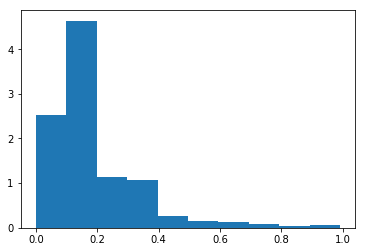

In [4]:
plt.hist(features['liveness'],density=True)

We're only interested in examining the studio versions. Since we'll focus on track and album similarity we want as little track repetitions or variations as possible. This means we'll get rid of demo and live versions. Most tracks are low in liveness anyway. 

In [5]:
albums = albums[~albums.album_name.str.contains('Live')]
albums = albums[~albums.album_name.str.contains('Deluxe')]

tracks = tracks[~(tracks.name.str.contains('Demo') & ~tracks.name.str.startswith('Demo'))]
tracks = tracks[~(tracks.name.str.contains('Live') 
                & ~ tracks.name.str.match('Live') 
                & ~tracks.name.isin(["Waking Lives","If I Could Live in This Montage,","I Would Rather Live Alone (I'm Not Who I'm Today)"]) )]

In [6]:
data = features.merge(tracks, on='id')
data  = data.merge(albums, on = 'album_id')
data = data.merge(artists[['artist_id','artist_name']], on='artist_id')

#get rid of christmas cover songs
data = data[~data.name.isin(["O Come, All Ye Faithful", "Silent Night", "O Holy Night",
                             "O Holy Night (Coke Studio)", "Jingle Bells", "Jingle Bells x Deck The Halls",
                            "Pasko, Pasko", "Pasko Na Sinta Ko - Live", "I'll Be Home For Christmas - Live",
                            "I'll Be Home for Christmas", "12 Days of Christmas", "This Christmas",
                             "Hark The Herald Angels Sing"])]

artists = artists[artists['artist_id'].isin(data.artist_id.unique())]
top_tracks = top_tracks.merge(data[['id','artist_name','album_name','release_date','acousticness', 'danceability', 'duration_ms', 'energy',
                                    'instrumentalness', 'key', 'loudness', 'mode', 'speechiness',
                                    'tempo', 'time_signature', 'valence']], on='id')

In [9]:
#if the exact same song was released as a single and as part of an album, we remove the single
duplicate_tracks = data[data.duplicated(subset=['name','artist_name'], keep=False)]
duplicate_tracks_same_albumtype = duplicate_tracks[duplicate_tracks.duplicated(subset=['name','artist_name','album_type'], keep=False)]
duplicate_tracks = duplicate_tracks.drop(labels=duplicate_tracks_same_albumtype.index) 
duplicate_tracks = duplicate_tracks[duplicate_tracks.album_type =='single'] 
data = data.drop(labels=duplicate_tracks.index)

In [10]:
#if it's part of the top tracks we get rid of the one not in the top tracks
duplicate_tracks_singles = duplicate_tracks_same_albumtype[duplicate_tracks_same_albumtype.album_type=='single']
match = duplicate_tracks_singles[duplicate_tracks_singles.id.isin(top_tracks.id)]
match_duplicate = duplicate_tracks_singles[duplicate_tracks_singles.name.isin(match.name.values) & duplicate_tracks_singles.artist_name.isin(match.artist_name.values)]
match_duplicate = match_duplicate.drop(labels = match.index)
data = data.drop(labels=match_duplicate.index)

In [11]:
#checked the tracks on spotify to figure out which to remove
duplicate_tracks_singles = data[data.duplicated(subset=['name','artist_name', 'album_type'], keep=False)]
duplicate_tracks_singles = duplicate_tracks_singles[duplicate_tracks_singles.album_type =='single'] 

In [12]:
data = data[~data.id.isin(['2EdGN7t9iqfO2nQuzYmwtG','2r8NNirF7wIVWgYub05M28','19W2Yf1HWW8t42X536FyiO',
                          '4bRUhryXD1j6yH8FhurXP5','4XMFzTqFfVg2kbg8QWZg3u','2PMwoczOBblVyWnPv1AtOK',
                          '2AVVScsrYvCaJEa0Em0nP3','7CPaxX4NpDCAsHu6l7Wgrf','1U2AAyiQxaAmhexAGbRBt5',
                          '2nj701qBR2sUQJJwIQDfH0','4gnB8ajjzYLUcT1fdP5Xgs','0pCVtVr8WwPfmi18UuJeoB',
                          '3EPi83nymQT8xpyhhkR97A','4Z96PCBJCm7luUC9pul1V6','1s1CzHJsngw5WepCKil5bx',
                          '5PZa3SFw3E4zvOCZwsxihx', '7Ipw44VKIGX8hAiyk5IWiB','21ZkQygETuUniq6QhD3R8k',
                          '2i6NSpxbELpP2W11bUOOwh','0NILwN8sesaYEfqZIqv3Ds','7o4wWaDR0cTcnOWD385o3O',
                          '0RsKqAMubnBiTeWl0gEzYY','6BhdY5rR9rCpSg5SJ8p68x', '6V8wIcmN2mmTGboC3mvpJ0',
                          '6jurqeA0oGtBq4AVZzFmwc','3D3iU9Lm7wsqxDHBPyuWGg','5R1FjVfqZgqaYZfdfCh3tf'])]

In [13]:
#there are still album duplicates, just not in the form of singles
duplicate_album_tracks = data[['name','artist_name','album_name','album_type','album_id']][data.duplicated(subset=['name','artist_name'], keep=False)]

In [14]:
#went through the all tracks to figure out which album and track to drop
data = data[~data.album_id.isin(['3KmhojVqDuGn5uHTvOPTyP','3S2wn2Fgagoh2kNAJHLL7D','6TwoE5Sbm4Ek6aA7wB4CrD',
                                '5240CJIWWatn8QeZz1e6Ch', '30IkggYSvncYoWo5LrzJrw'])]

3KmhojVqDuGn5uHTvOPTyP - extra info behind the songs and the album

3S2wn2Fgagoh2kNAJHLL7D,6TwoE5Sbm4Ek6aA7wB4CrD - open.spotify.com had the same two albums but with different album links for each. The album the spotify app linked to was chosen to remain.

5240CJIWWatn8QeZz1e6Ch - live songs

30IkggYSvncYoWo5LrzJrw - same songs but with a different naming scheme

We'll remove tracks shorter than a minute since most of them are used as intros or album fillers, like Maya, a 39 second track of birds chirping. 


Other fillers include:

CLAPCLAPCLAP! which is a short track with only clapping.

Obligatory Hipster Filler (0:13) which sounds like someone opening a box.

In [15]:
og_len = len(data)
data = data[data.duration_ms > 60000] #60000 miliseconds is a minute
print(og_len-len(data))
print((og_len-len(data))/og_len)

34
0.014623655913978495


That gets rid of 34 tracks, which accounts for 1.4% of the population count.

In [16]:
#tracks that have more than one artist
data_multiple_artists = data[['id','name','album_name','album_type','artist_name']][data.duplicated(subset=['id'], keep=False)].sort_values(by=['name'])

#only keep one track for tracks that have multiple artists
mult_artists_drop = data[data.duplicated(subset=['id'])]
data = data.drop(labels=mult_artists_drop.index)

# Spotify Audio Features

Spotify makes recommendations based on the following features:

    
Mood: Danceability, Valence, Energy, Tempo

Properties: Loudness, Speechiness, Instrumentalness

Context: Liveness, Acousticness

Segments, Tatums, Bars, Beats, Pitches, Timbre, and more


In [18]:
data.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy', 'id',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'name',
       'preview_url', 'album_id', 'album_type', 'artist_id', 'image_300',
       'image_64', 'image_640', 'album_name', 'release_date', 'artist_name'],
      dtype='object')

In [19]:
col = ['acousticness','danceability','energy','instrumentalness','speechiness','valence','loudness','tempo']

### Track Similarity

We'll start with the columns above since each has one value for each track, whereas the segments, tatums etc. have multiple.

Echonest, and by extension Spotify, used these features as a basis for their music recommendations.

However, unlike Spotify, we won't include liveness.

Text(0.5, 1.0, 'Track Similarity Distribution')

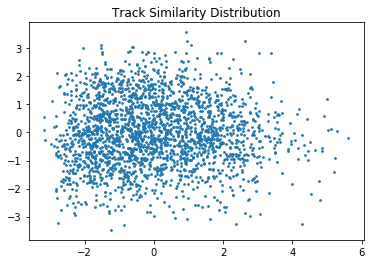

In [20]:
#PCA with normalization
X = data[col]

#we need to scale since the loudness is measured in decibels
scaler = StandardScaler()
standardized_X = scaler.fit_transform(X)

reduced_data = PCA(n_components=2).fit_transform(standardized_X)

plt.scatter(reduced_data[:,0],reduced_data[:,1], s=3) 
plt.title("Track Similarity Distribution")

In [21]:
len(reduced_data)

2276

In [22]:
test = pd.DataFrame(reduced_data)
test['name'] = data['name'].values
test['artist_name'] = data['artist_name'].values
upper_0 = test[test[0]>5].sort_values([0], ascending=False)
upper_0

0         1                           name    artist_name
1952  5.615921 -0.214522                     Riverchild    Clara Benin
1949  5.281248  0.058107                       December    Clara Benin
1564  5.239802 -0.924688                         Falter         lluwin
1557  5.187773 -1.417891                           Born         lluwin
2087  5.124650  0.110414  Slide (feat. Keiko Necesario)  Dane Hipolito
1948  5.023796  0.083131      Riverchild - Instrumental    Clara Benin

In [23]:
len(test)

2276

In [24]:
upper_1 = test[test[1]>3].sort_values([1], ascending=False)
upper_1

0         1                             name         artist_name
813   0.913661  3.564131  Kumusta Kadiliman - Spoken Word  Juan Miguel Severo
333   0.942588  3.263129                     Grammar Nazi     Reese Lansangan
1274  2.643302  3.262140                            Hanap             Because
1731 -1.512707  3.102369                      SakaLawakan   Assembly Generals
1983  1.058454  3.098781                        Palpitate                Asch
1097 -0.639893  3.038671            Process (feat. Awich)       Jess Connelly
365  -0.604938  3.032326                        Manlalako        Bullet Dumas
1232 -1.518026  3.024338                    Bobby Bobbito          Bawal Clan
1736 -2.058328  3.005251                 Fire in the Hole   Assembly Generals

Text(0.5, 1.0, 'Track Similarity Distribution')

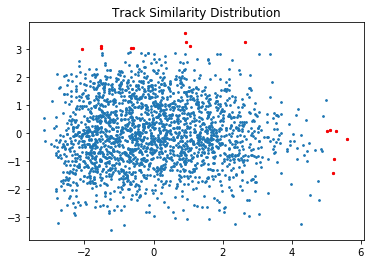

In [25]:
plt.scatter(reduced_data[:,0],reduced_data[:,1], s=3) 
plt.scatter(upper_0[0],upper_0[1], s=5, color='red') 
plt.scatter(upper_1[0],upper_1[1], s=5, color='red') 

plt.title("Track Similarity Distribution")

It's not clear why these tracks are far from the rest.

Let's take a look at the distribution of the features.

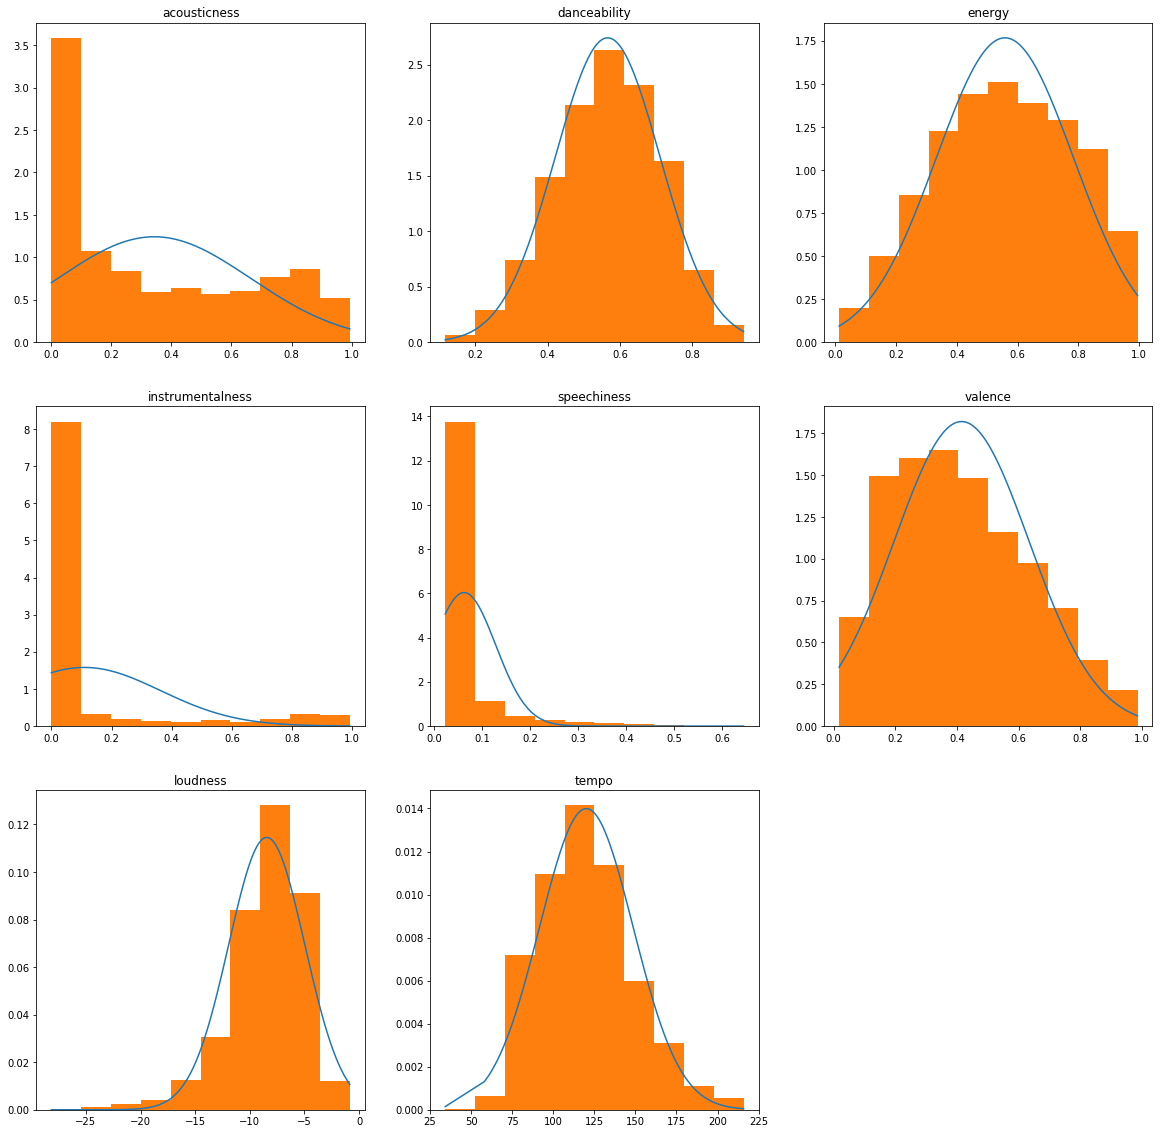

In [26]:
plt.figure(figsize=(20,20))
for idx, column in enumerate(X.columns):
    h = sorted(X[column])  #sorted
    fit = stats.norm.pdf(h, np.mean(h), np.std(h))
    
    plt.subplot(3,3,idx+1)
    plt.plot(h,fit)
    plt.hist(h,density=True) 
    plt.title(column)

     #use this to draw histogram of your data
plt.show()

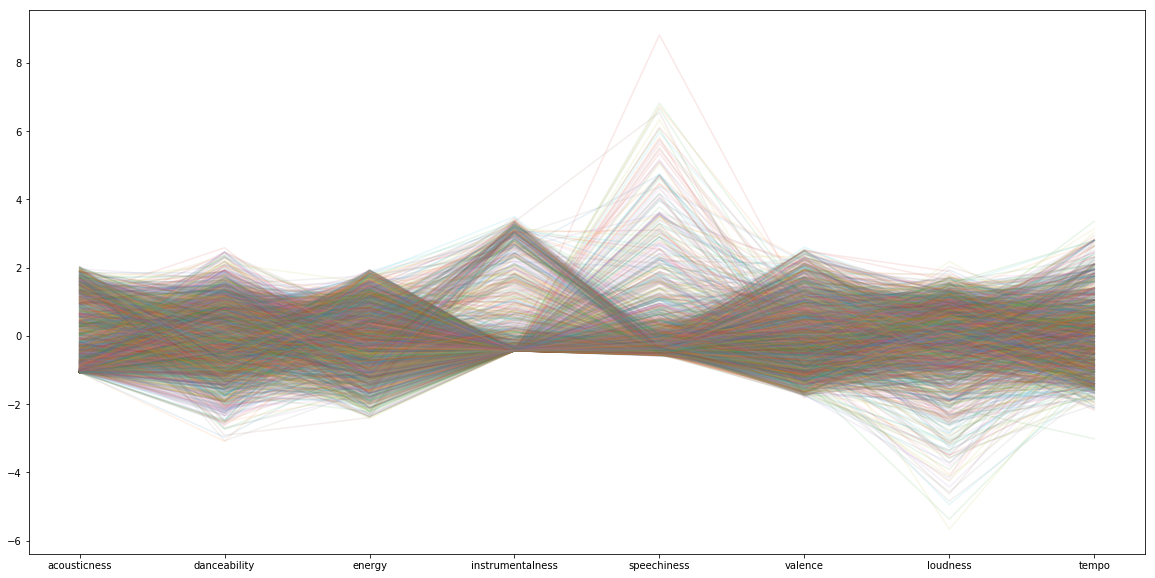

In [27]:
#Standard Scaler 
scaler = StandardScaler() 
#we need to scale since the loudness is measured in decibels
Y = pd.DataFrame(scaler.fit_transform(X), columns = col)

plt.figure(figsize=(20,10))
line = plt.plot(Y.columns, Y.T,alpha=0.1)

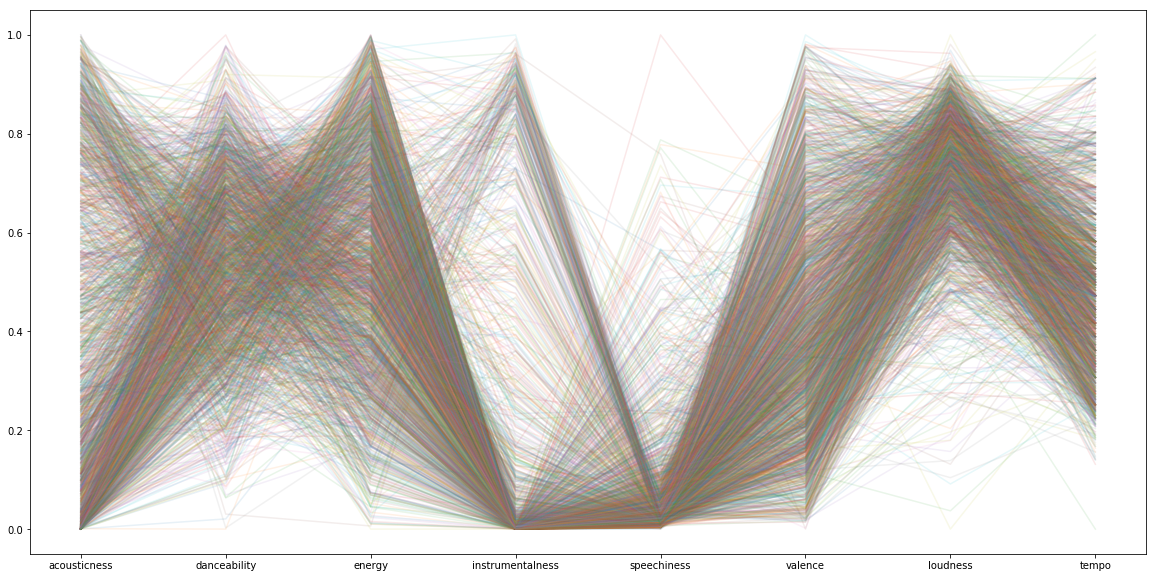

In [28]:
#Min-max scaler is sensitive to outliers
minmax_scaler = MinMaxScaler() 
#we need to scale since the loudness is measured in decibels
Y_minmax = pd.DataFrame(minmax_scaler.fit_transform(X), columns = col)

plt.figure(figsize=(20,10))
line = plt.plot(Y_minmax.columns, Y_minmax.T,alpha=0.1)

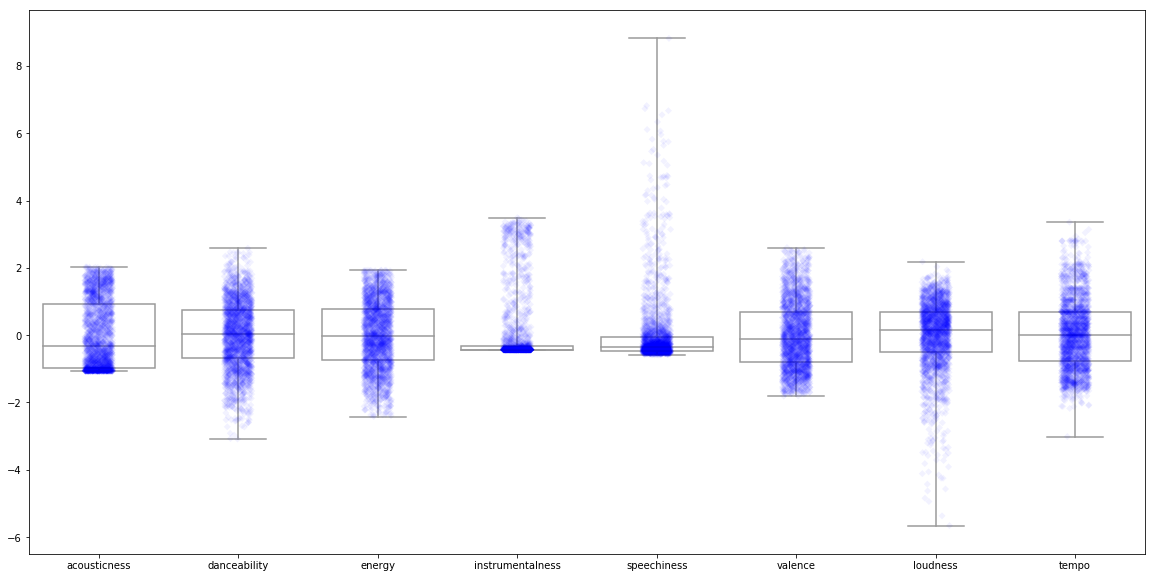

In [29]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=Y, whis=np.inf, color='white')
ax = sns.stripplot(data=Y, color="blue",alpha=.05, marker='D', edgecolor="black")

In [30]:
X.describe()

acousticness  danceability       energy  instrumentalness  speechiness  \
count   2276.000000   2276.000000  2276.000000       2276.000000  2276.000000   
mean       0.342769      0.566082     0.558499          0.109832     0.062326   
std        0.320997      0.145484     0.225726          0.252593     0.066082   
min        0.000004      0.117000     0.012600          0.000000     0.023200   
25%        0.033975      0.466000     0.390000          0.000002     0.032000   
50%        0.242000      0.571000     0.556000          0.000257     0.039200   
75%        0.642000      0.674000     0.736250          0.025025     0.059100   
max        0.994000      0.942000     0.995000          0.992000     0.645000   

           valence     loudness        tempo  
count  2276.000000  2276.000000  2276.000000  
mean      0.415174    -8.445936   120.138124  
std       0.219260     3.483563    28.516151  
min       0.017900   -28.157000    34.251000  
25%       0.237000   -10.149250    98.058000  
50%       0.389500    -7.918500   119.921000  
75%       0.569000    -6.056500   139.384750  
max       0.986000    -0.849000   215.900000

Most songs are close to zero in acousticness, with a somewhat even distribution for the other values of acousticness. 

Danceability tends to cluster around the mean 0.56, suggesting that most songs are moderate in danceability. There are outliers on the low end of danceability.

Energy and valence are varied--their means are close to 0.5 and have a skewed distribution.

Majority of the songs rank are close to zero in instrumentalness and speechiness. Both have heavy tails. 

Most songs are loud. 

Tempo averages to about 120 bpm and have few outliers with a high tempo and one with a low tempo.

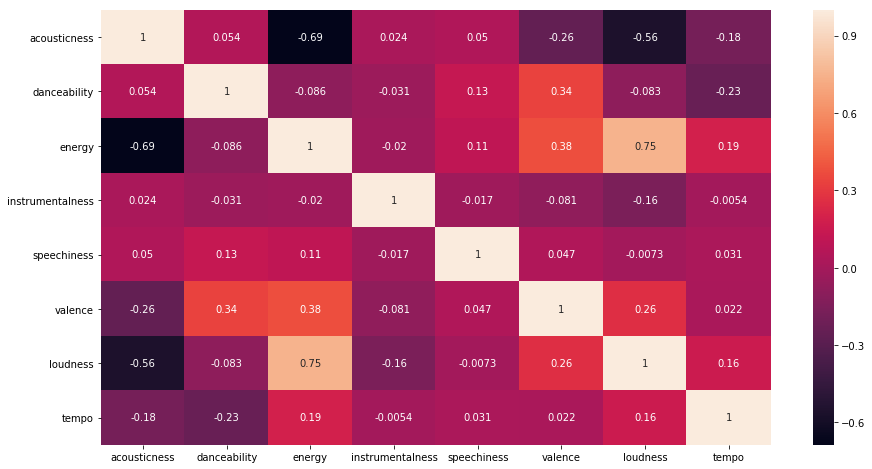

In [31]:
plt.figure(figsize=(15, 8))
corr = X.corr()
sns.heatmap(corr, 
            xticklabels=X.columns.values,
            yticklabels=X.columns.values,
            annot=True)

Noticeable positive correlations:

Energy and loudness - This makes sense. Typically, energetic tracks feel fast, loud, and noisy.

Noticeable negative correlations:

Acousticness and energy

Acousticness and loudness

The rest have little correlation. I'm surprised that energy and danceability aren't correlated.

Let's group the tracks based on feature similarity.

Text(0, 0.5, 'Sum of squared distance')

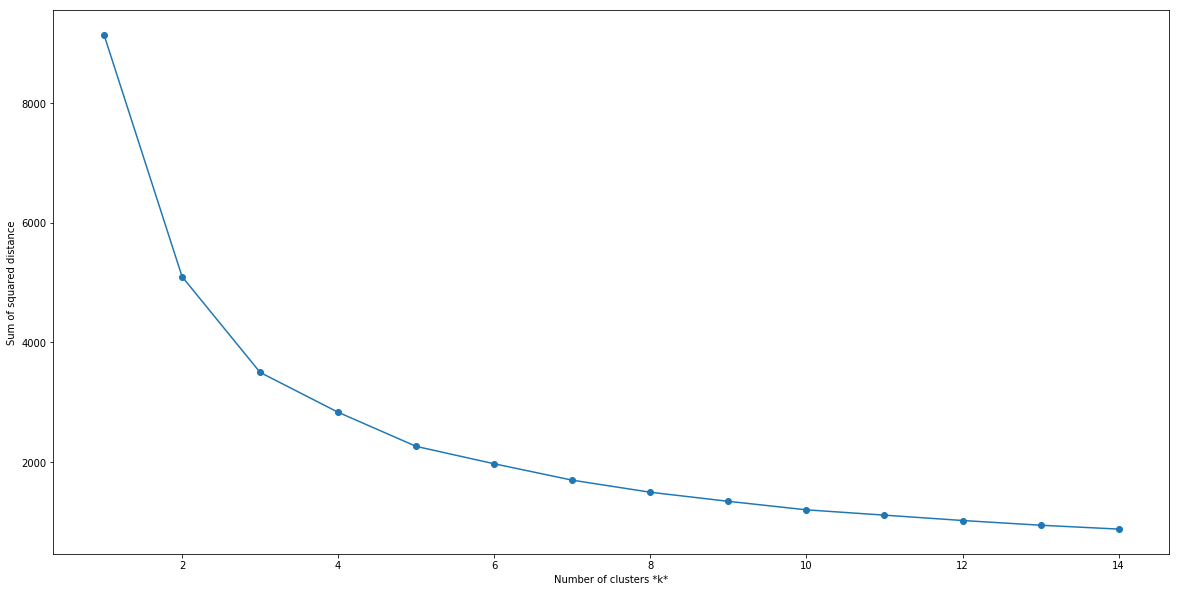

In [32]:
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(reduced_data)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(20, 10))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

Elbow method used to determine the number of clusters.

In [33]:
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(reduced_data)

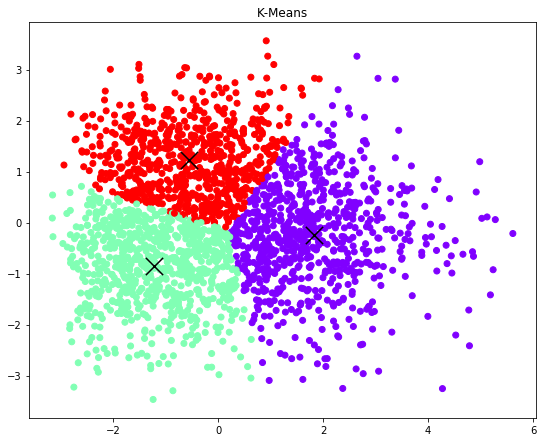

In [34]:
plt.figure(figsize=(20,16))
plt.subplot(221, title='K-Means')
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=kmeans.labels_, cmap='rainbow')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=300, linewidths=3,
            color='black', zorder=10)

In [35]:
clustered_data = pd.DataFrame()
clustered_data['cluster'] = kmeans.labels_
clustered_data['id'] = data['id'].values
clustered_data['name'] = data['name'].values
clustered_data['artist_name'] = data['artist_name'].values
clustered_data = pd.concat([clustered_data, X], axis=1)
clustered_data.head()

cluster                      id                                   name  \
0      0.0  3kFDnFj6asUJsUPodsWT2o  Away from the Current (Piano Version)   
1      1.0  1I4FVXxMHTy07BvPO1mVjA                                 Blithe   
2      0.0  2IFNR24j14O8IuqLxFr0NT                      Let Me Be The One   
3      0.0  4FrzR2A8kmSKB87Nx2oZjR                            Ikaw Pa Rin   
4      2.0  2vqAmth0yZZbBxwmVdE9V2                              Panaginip   

       artist_name  acousticness  danceability  energy  instrumentalness  \
0  Keiko Necesario         0.936         0.534   0.178          0.000000   
1  Keiko Necesario         0.229         0.515   0.529          0.000077   
2  Keiko Necesario         0.920         0.584   0.186          0.000000   
3  Keiko Necesario         0.964         0.508   0.252          0.000001   
4  Keiko Necesario           NaN           NaN     NaN               NaN   

   speechiness  valence  loudness    tempo  
0       0.0341    0.300   -11.953   94.948  
1       0.0466    0.181    -9.493  127.424  
2       0.0422    0.238    -9.272  107.885  
3       0.0274    0.251    -7.917  140.185  
4          NaN      NaN       NaN      NaN

In [32]:
clustered_data[clustered_data['cluster']==0]

cluster                      id  \
4         0.0  2vqAmth0yZZbBxwmVdE9V2   
9         0.0  54Xd504CFfd9jWTcpNPg2U   
10        0.0  0ghwbO2V01fXhpMMwx0sw1   
12        0.0  7MwvSPbO4n8hVVM8Hdjg7F   
22        0.0  52YWyznut721L6RHxl86Cz   
26        0.0  3a7c8dRD2v3afhAPPnFOfp   
33        0.0  6NQK3PUIcPWXxQvkhC6R5A   
46        0.0  6EGqxvmpZKTbcii9aU6VNN   
50        0.0  2lTCcfrukFA5bQ9bpJkNNG   
69        0.0  7pbUwF5C6pkv3Jsg1fdOIh   
70        0.0  65AxjiINZ9Fu0Di6PjVFon   
71        0.0  4vPE0oE5cENck5VaIcbCJw   
72        0.0  72J8iHCKk2cJ59n1f2OrLn   
73        0.0  0wgAHIBpHWMSWcg5HBcypr   
76        0.0  2jqTYdSQLmkp5dtOICI3S9   
79        0.0  0MCPPARwas3iMZxTyhbJcI   
125       0.0  2AKkC45jJp4D0t8Bxwp9QX   
141       0.0  2GMD4U529k1yFNq8G5snQO   
143       0.0  6V9lkw6Ud15RG5a7iLKDra   
145       0.0  6ARYi42spRNIZpjd0WcDnf   
148       0.0  5VvVjk3z9wfpeLpQCFpD8a   
149       0.0  0hpBwfrWHT4ZYDsHqPpwYR   
150       0.0  1r0u9crAlIqyyFJv8dJKy7   
151       0.0  0DdC92EziGIEN6j7kTCKQX   
152       0.0  3T8yMLawoliJaN1hAGFFmv   
154       0.0  3iANkEVyUqLHrdIT61Ylze   
158       0.0  2H7z6l6EknhQ8Mi27vELkS   
162       0.0  0edPMtX93wQTFxEgq9ue7C   
178       0.0  5NwgVC2bFG0JJmaljJUFGG   
179       0.0  1zuDW6Ru2Hwa0AmnBcy0SS   
...       ...                     ...   
2140      0.0  3Wn6SHbOazOKg3um66E8mS   
2144      0.0  2f8ke620DZZtwelB0IEdOH   
2145      0.0  12Bf0t77kzovmj7Uqg1zfs   
2149      0.0  2AF8pNbXG5g1RUik7zw7vB   
2150      0.0  7rxpPcF07uanGUxhSUiujc   
2167      0.0  2aRAvsmWbOLn6pVpixUiOn   
2169      0.0  5FNwinM132PAr9wzMidYHG   
2175      0.0  2bvBA4Vk22XUIacl1jzKo8   
2178      0.0  5l9g7py8RCblcvbZgGQgSd   
2181      0.0  7xzHDGXxOdIJcg2cyysE8i   
2185      0.0  3uSLCrfK2gvBZ6OUuAdawA   
2188      0.0  4m9kyXFCkyQewLshQBI9mC   
2194      0.0  48Utf6gNBC9rewCPEvL5ja   
2196      0.0  1yDiru08Q6omDOGkZMPnei   
2199      0.0  1fXHTDYsJiFOjVWITaFp1j   
2201      0.0  0MknHrnfqj1jjLMYCs6S0p   
2202      0.0  6AmDnCqE8p7efyDy2EDjgG   
2205      0.0  3CM9A4BxQa0WjAOleeyvoh   
2206      0.0  5w879hUsy3nYYMjg0rNQYS   
2207      0.0  2jjuzjDbmVOI7kNCSxy5e4   
2208      0.0  6InVPJLNbia2XBqDUVqxWy   
2211      0.0  5irMjX5Vwpod35QD0t5NXU   
2218      0.0  1SO2BUpftxAFQlm1awTTf8   
2225      0.0  3HpZvG3U0QK1cmr32AZPNO   
2227      0.0  3ESQ22vx2GtAV1SW1pD3aQ   
2228      0.0  3S3xWmqjYSAjj1LtnmX4nE   
2246      0.0  6KHQaiA5qZ0MipB82rPbgO   
2247      0.0  7M3oD7QYq67yiezdTWmxT9   
2253      0.0  0C9EbuJ0txsHQImgriJQWM   
2256      0.0  2rgWCbWlCCdO5ektVDFSQQ   

                                               name        artist_name  \
4                                         Panaginip    Keiko Necesario   
9                                While We Are Young    Keiko Necesario   
10                                          Highway    Keiko Necesario   
12                                  Highway - Remix    Keiko Necesario   
22     Ang Probinsyano - Theme from Ang Probinsyano         Ebe Dancel   
26                   Ang Panday - From "Ang Panday"         Ebe Dancel   
33                                          Padayon         Ebe Dancel   
46                                       Hindi Alam          Autotelic   
50                                       Takipsilim          Autotelic   
69                                            Logic   B. P. Valenzuela   
70                                           Steady   B. P. Valenzuela   
71                                      Like Letter   B. P. Valenzuela   
72                                     Building Too   B. P. Valenzuela   
73                                          Veneers   B. P. Valenzuela   
76                           The Fury and the Sound   B. P. Valenzuela   
79                                         Minimize   B. P. Valenzuela   
125                                  Dear Classmate         Mayonnaise   
141                                 Soul For A Kiss              Kjwan   
143                                           Helix      

Why was it grouped this way? 

In [33]:
clustered_data[clustered_data['artist_name']=='Keiko Necesario']

cluster                      id                                   name  \
0       1.0  3kFDnFj6asUJsUPodsWT2o  Away from the Current (Piano Version)   
1       2.0  1I4FVXxMHTy07BvPO1mVjA                                 Blithe   
2       1.0  2IFNR24j14O8IuqLxFr0NT                      Let Me Be The One   
3       1.0  4FrzR2A8kmSKB87Nx2oZjR                            Ikaw Pa Rin   
4       0.0  2vqAmth0yZZbBxwmVdE9V2                              Panaginip   
5       1.0  39fNON9tzWSkuLbpGAHJnD                             Connection   
6       1.0  23GURsZ8hfMKVjUpm16IMq              Maybe in Another Lifetime   
7       1.0  06AxnsCACcLbrkVVCA6UCv                              Paano Na?   
8       2.0  6b5pWdPQy9i85vBZR3pl2T                             Di Bale Na   
9       0.0  54Xd504CFfd9jWTcpNPg2U                     While We Are Young   
10      0.0  0ghwbO2V01fXhpMMwx0sw1                                Highway   
11      1.0  6KCKbh4PXZGP7Rykg2v6gj                                 Escape   
12      0.0  7MwvSPbO4n8hVVM8Hdjg7F                        Highway - Remix   

        artist_name  acousticness  danceability  energy  instrumentalness  \
0   Keiko Necesario        0.9360         0.534   0.178          0.000000   
1   Keiko Necesario        0.2290         0.515   0.529          0.000077   
2   Keiko Necesario        0.9200         0.584   0.186          0.000000   
3   Keiko Necesario        0.9640         0.508   0.252          0.000001   
4   Keiko Necesario           NaN           NaN     NaN               NaN   
5   Keiko Necesario        0.1740         0.686   0.674          0.000025   
6   Keiko Necesario        0.8390         0.331   0.150          0.000007   
7   Keiko Necesario        0.8760         0.423   0.208          0.000016   
8   Keiko Necesario           NaN           NaN     NaN               NaN   
9   Keiko Necesario        0.8930         0.415   0.107          0.000000   
10  Keiko Necesario        0.4820         0.502   0.551          0.000267   
11  Keiko Necesario           NaN           NaN     NaN               NaN   
12  Keiko Necesario        0.0341         0.813   0.596          0.000008   

    speechiness  valence  loudness    tempo  
0        0.0341    0.300   -11.953   94.948  
1        0.0466    0.181    -9.493  127.424  
2        0.0422    0.238    -9.272  107.885  
3        0.0274    0.251    -7.917  140.185  
4           NaN      NaN       NaN      NaN  
5        0.0248    0.664    -6.303  110.965  
6        0.0338    0.188   -14.474  124.085  
7        0.0362    0.234   -12.925  138.778  
8           NaN      NaN       NaN      NaN  
9        0.0398    0.270   -12.278  125.344  
10       0.0422    0.291    -8.494  171.988  
11          NaN      NaN       NaN      NaN  
12       0.0487    0.706    -7.322  116.067

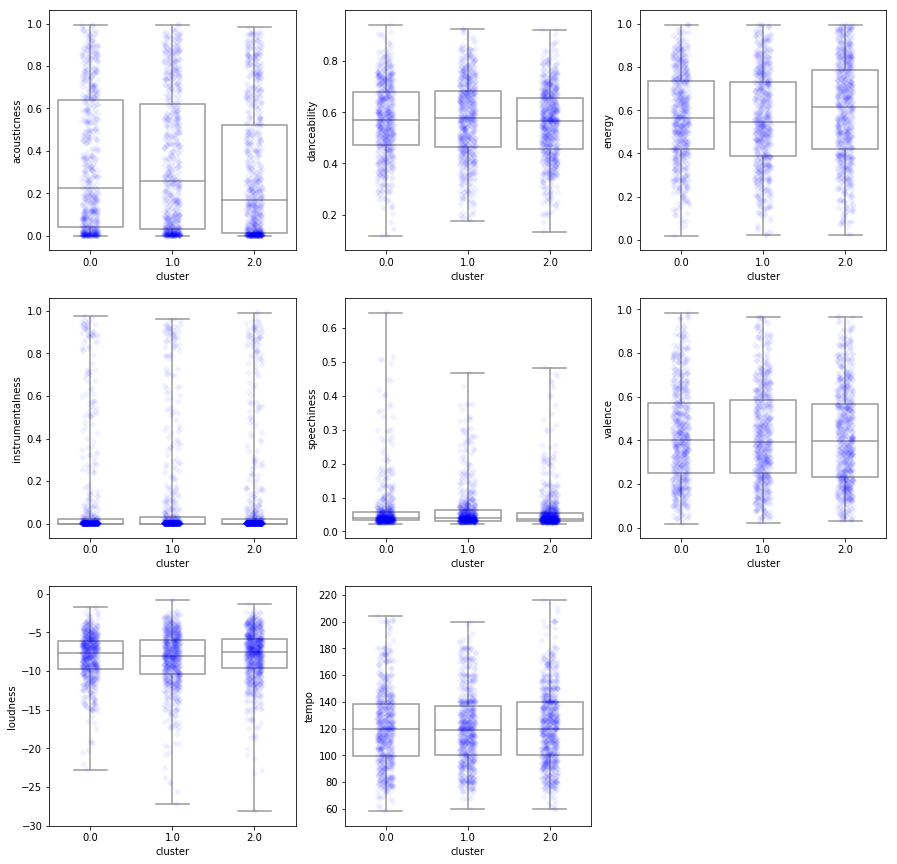

In [34]:
clustered_data_simplfified = clustered_data[['cluster','acousticness','danceability','energy','instrumentalness',
          'speechiness','valence','loudness','tempo']]

clustered_data_features = clustered_data[['acousticness','danceability','energy','instrumentalness',
          'speechiness','valence','loudness','tempo']]

plt.figure (figsize=(15,15))

for idx,cl in enumerate(clustered_data_features.columns):
    plt.subplot(3,3,idx+1)
    ax = sns.boxplot(x='cluster', y=cl, data=clustered_data_simplfified, whis=np.inf, color='white')
    ax = sns.stripplot(x='cluster', y=cl, data=clustered_data_simplfified, color="blue",alpha=.05, marker='D', edgecolor="black")


It's not clear why the tracks were clustered in this way. The mean and spread of features across all clusters are too similar.

### Track Mood

Let's take a closer look at the mood of the tracks.

Text(0.5, 1.0, 'Mood Similarity Distribution')

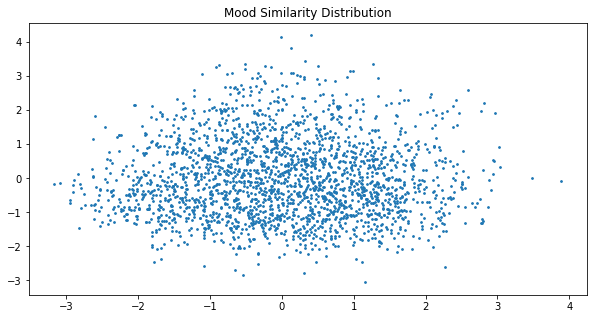

In [35]:
mood_X = Y[['danceability', 'valence', 'energy', 'tempo']]
reduced_mood = PCA(n_components=2).fit_transform(mood_X)

plt.figure(figsize=(10,5))

plt.scatter(reduced_mood[:,0],reduced_mood[:,1], s=3) 
plt.title("Mood Similarity Distribution")

Text(0, 0.5, 'Sum of squared distance')

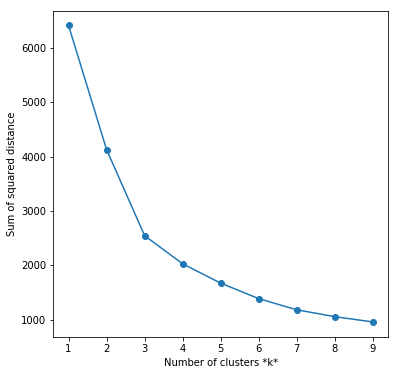

In [36]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(reduced_mood)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [37]:
kmeans = KMeans(n_clusters=3).fit(reduced_mood)

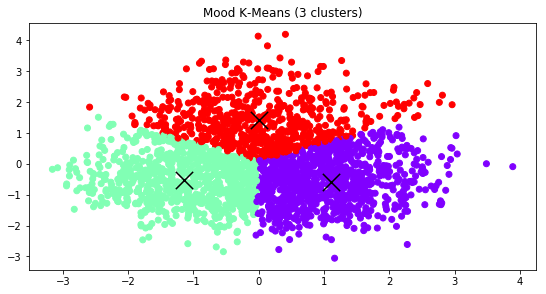

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(221, title='Mood K-Means (3 clusters)')
plt.scatter(reduced_mood[:,0], reduced_mood[:,1], c=kmeans.labels_, cmap='rainbow')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=300, linewidths=3,
            color='black', zorder=10)


In [39]:
mood_cluster = pd.DataFrame()
mood_cluster['cluster'] = kmeans.labels_
mood_cluster['name'] = data['name'].values
mood_cluster['artist_name'] = data['artist_name'].values
mood_cluster['id'] = data['id'].values
mood_cluster = pd.concat([mood_cluster,Y[['danceability', 'valence', 'energy', 'tempo']] ], axis=1)
mood_cluster.head()

cluster                                   name      artist_name  \
0        0  Away from the Current (Piano Version)  Keiko Necesario   
1        0                                 Blithe  Keiko Necesario   
2        0                      Let Me Be The One  Keiko Necesario   
3        0                            Ikaw Pa Rin  Keiko Necesario   
4        1                              Panaginip  Keiko Necesario   

                       id  danceability   valence    energy     tempo  
0  3kFDnFj6asUJsUPodsWT2o     -0.220568 -0.525403 -1.686036 -0.883558  
1  1I4FVXxMHTy07BvPO1mVjA     -0.351195 -1.068257 -0.130713  0.255556  
2  2IFNR24j14O8IuqLxFr0NT      0.123187 -0.808235 -1.650587 -0.429785  
3  4FrzR2A8kmSKB87Nx2oZjR     -0.399320 -0.748931 -1.358133  0.703155  
4  2vqAmth0yZZbBxwmVdE9V2      0.824447  1.135093  0.511800 -0.321752

In [40]:
mood_cluster[mood_cluster['artist_name']=='Keiko Necesario']

cluster                                   name      artist_name  \
0         0  Away from the Current (Piano Version)  Keiko Necesario   
1         0                                 Blithe  Keiko Necesario   
2         0                      Let Me Be The One  Keiko Necesario   
3         0                            Ikaw Pa Rin  Keiko Necesario   
4         1                              Panaginip  Keiko Necesario   
5         0                             Connection  Keiko Necesario   
6         0              Maybe in Another Lifetime  Keiko Necesario   
7         0                              Paano Na?  Keiko Necesario   
8         2                             Di Bale Na  Keiko Necesario   
9         1                     While We Are Young  Keiko Necesario   
10        1                                Highway  Keiko Necesario   
11        2                                 Escape  Keiko Necesario   
12        1                        Highway - Remix  Keiko Necesario   

                        id  danceability   valence    energy     tempo  
0   3kFDnFj6asUJsUPodsWT2o     -0.220568 -0.525403 -1.686036 -0.883558  
1   1I4FVXxMHTy07BvPO1mVjA     -0.351195 -1.068257 -0.130713  0.255556  
2   2IFNR24j14O8IuqLxFr0NT      0.123187 -0.808235 -1.650587 -0.429785  
3   4FrzR2A8kmSKB87Nx2oZjR     -0.399320 -0.748931 -1.358133  0.703155  
4   2vqAmth0yZZbBxwmVdE9V2      0.824447  1.135093  0.511800 -0.321752  
5   39fNON9tzWSkuLbpGAHJnD     -1.616212 -1.036325 -1.810108  0.138439  
6   23GURsZ8hfMKVjUpm16IMq     -0.983703 -0.826482 -1.553103  0.653804  
7   06AxnsCACcLbrkVVCA6UCv     -1.038704 -0.662257 -2.000646  0.182599  
8   6b5pWdPQy9i85vBZR3pl2T     -0.440571 -0.566459 -0.033228  1.818663  
9   54Xd504CFfd9jWTcpNPg2U      1.697584  1.326689  0.166173 -0.142797  
10  0ghwbO2V01fXhpMMwx0sw1     -0.557448  1.303880  0.463058 -1.243573  
11  6KCKbh4PXZGP7Rykg2v6gj     -0.165567 -1.050010 -0.179455  0.979060  
12  7MwvSPbO4n8hVVM8Hdjg7F      0.631944  0.596800  0.963774  0.980638

Why were they clustered this way? What mood can we attribute to each cluster? Let's see if there's any correlation between their cluster and feature.

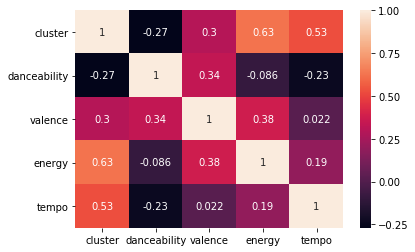

In [41]:
mood_corr = mood_cluster[['cluster','danceability', 'valence', 'energy', 'tempo']]
corr = mood_corr.corr()
sns.heatmap(corr, 
            xticklabels=mood_corr.columns.values,
            yticklabels=mood_corr.columns.values,
           annot=True)

Cluster correlates with valence and energy.

In [42]:
mood_0 = mood_cluster[mood_cluster['cluster']==0]

mood_0 = mood_0[['danceability', 'valence', 'energy', 'tempo']]
mood_0.describe()

danceability     valence      energy       tempo
count    826.000000  826.000000  826.000000  826.000000
mean      -0.049523   -0.780106   -0.871780   -0.440947
std        0.920847    0.539339    0.679862    0.824212
min       -3.073732   -1.812287   -2.418944   -3.012538
25%       -0.667449   -1.185724   -1.342624   -1.128236
50%       -0.014315   -0.844729   -0.875141   -0.426663
75%        0.590693   -0.388549   -0.369993    0.213904
max        2.467594    0.907003    1.566407    2.099197

In [43]:
mood_cluster[mood_cluster['cluster']==0].head()

cluster                                   name      artist_name  \
0        0  Away from the Current (Piano Version)  Keiko Necesario   
1        0                                 Blithe  Keiko Necesario   
2        0                      Let Me Be The One  Keiko Necesario   
3        0                            Ikaw Pa Rin  Keiko Necesario   
5        0                             Connection  Keiko Necesario   

                       id  danceability   valence    energy     tempo  
0  3kFDnFj6asUJsUPodsWT2o     -0.220568 -0.525403 -1.686036 -0.883558  
1  1I4FVXxMHTy07BvPO1mVjA     -0.351195 -1.068257 -0.130713  0.255556  
2  2IFNR24j14O8IuqLxFr0NT      0.123187 -0.808235 -1.650587 -0.429785  
3  4FrzR2A8kmSKB87Nx2oZjR     -0.399320 -0.748931 -1.358133  0.703155  
5  39fNON9tzWSkuLbpGAHJnD     -1.616212 -1.036325 -1.810108  0.138439

In [44]:
mood_cluster[mood_cluster['cluster']==1].head()

cluster                             name      artist_name  \
4         1                        Panaginip  Keiko Necesario   
9         1               While We Are Young  Keiko Necesario   
10        1                          Highway  Keiko Necesario   
12        1                  Highway - Remix  Keiko Necesario   
20        1  Padayon - Theme from Kid Kulafu       Ebe Dancel   

                        id  danceability   valence    energy     tempo  
4   2vqAmth0yZZbBxwmVdE9V2      0.824447  1.135093  0.511800 -0.321752  
9   54Xd504CFfd9jWTcpNPg2U      1.697584  1.326689  0.166173 -0.142797  
10  0ghwbO2V01fXhpMMwx0sw1     -0.557448  1.303880  0.463058 -1.243573  
12  7MwvSPbO4n8hVVM8Hdjg7F      0.631944  0.596800  0.963774  0.980638  
20  10KwgxxuINm8qfrscMSyog      0.102562  1.212644  0.848565  0.839354

In [45]:
mood_cluster[mood_cluster['cluster']==2].head()

cluster        name      artist_name                      id  \
8         2  Di Bale Na  Keiko Necesario  6b5pWdPQy9i85vBZR3pl2T   
11        2      Escape  Keiko Necesario  6KCKbh4PXZGP7Rykg2v6gj   
13        2  Bawat Daan       Ebe Dancel  0wUSZjJVblGKntOqBSWMdo   
14        2     Kasayaw       Ebe Dancel  1PylPQlmQ2ymbRFtEqs3NM   
15        2        Prom       Ebe Dancel  461EfHiwzh8ZCZGaFEIaAJ   

    danceability   valence    energy     tempo  
8      -0.440571 -0.566459 -0.033228  1.818663  
11     -0.165567 -1.050010 -0.179455  0.979060  
13     -2.317472 -0.561897  0.613716  1.125851  
14     -0.076191  0.022013 -0.937177  1.114662  
15     -0.667449 -0.383987  0.844134  0.841283

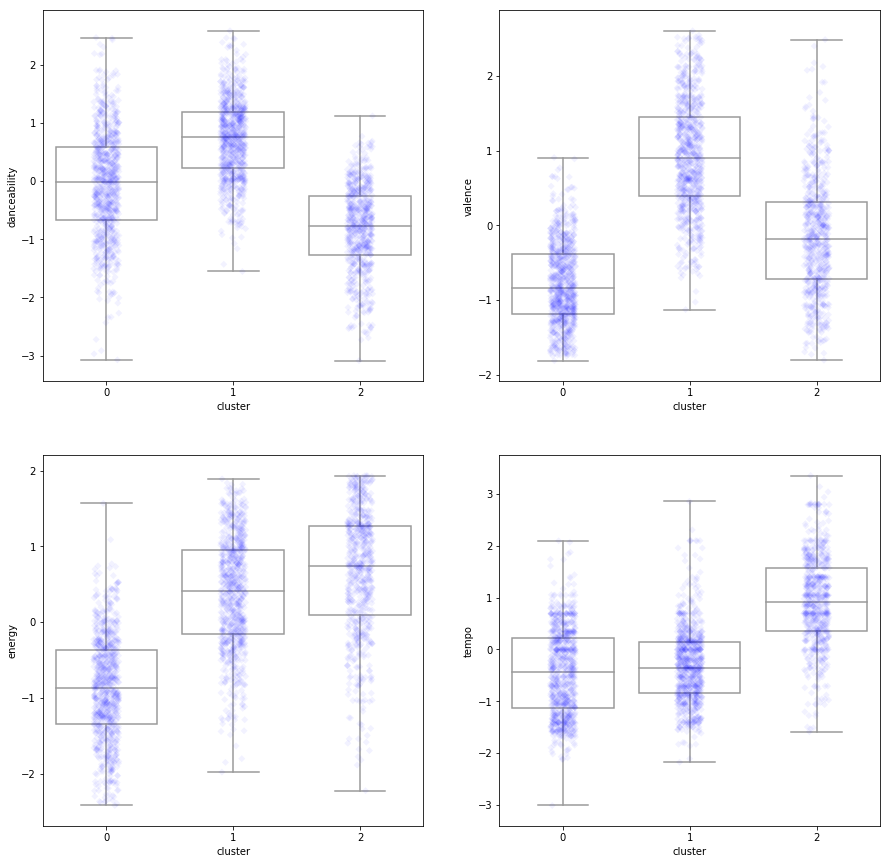

In [46]:
plt.figure (figsize=(15,15))

for idx,col in enumerate(mood_0.columns):
    plt.subplot(2,2,idx+1)
    ax = sns.boxplot(x='cluster', y=col, data=mood_corr, whis=np.inf, color='white')
    ax = sns.stripplot(x='cluster', y=col, data=mood_corr, color="blue",alpha=.05, marker='D', edgecolor="black")


Cluster 0:
low danceability, medium valence/positivity, high energy, high tempo

Cluster 1:
medium danceability, low valence/positivity, low energy, low-average tempo

Cluster 2:
high danceability, high valence/positivity, medium-high energy, low-average tempo

### Track Properties

Text(0.5, 1.0, 'Property Similarity Distribution')

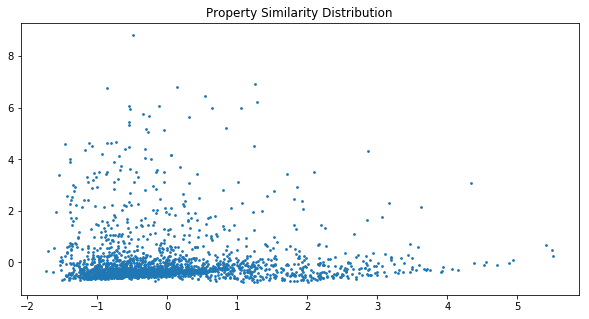

In [47]:
properties = ['loudness', 'speechiness', 'instrumentalness']
properties_X = scaler.fit_transform(X[properties])
reduced_properties = PCA(n_components=2).fit_transform(properties_X)

plt.figure(figsize=(10,5))

plt.scatter(reduced_properties[:,0],reduced_properties[:,1], s=3) 
plt.title("Property Similarity Distribution")

Text(0, 0.5, 'Sum of squared distance')

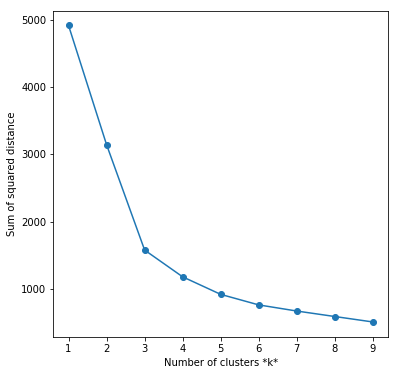

In [48]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(reduced_properties)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [49]:
kmeans = KMeans(n_clusters=3).fit(reduced_properties)

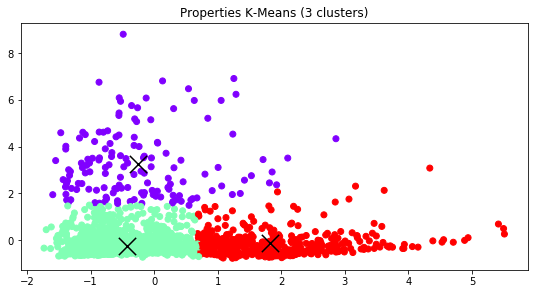

In [50]:
plt.figure(figsize=(20,10))
plt.subplot(221, title='Properties K-Means (3 clusters)')
plt.scatter(reduced_properties[:,0], reduced_properties[:,1], c=kmeans.labels_, cmap='rainbow')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=300, linewidths=3,
            color='black', zorder=10)

In [51]:
properties_cluster = pd.DataFrame()
properties_cluster['cluster'] = kmeans.labels_
properties_cluster['name'] = data['name'].values
properties_cluster['artist_name'] = data['artist_name'].values
properties_cluster['id'] = data['id'].values
properties_cluster = pd.concat([properties_cluster,Y[properties] ], axis=1)
properties_cluster.head()

cluster                                   name      artist_name  \
0        1  Away from the Current (Piano Version)  Keiko Necesario   
1        1                                 Blithe  Keiko Necesario   
2        1                      Let Me Be The One  Keiko Necesario   
3        1                            Ikaw Pa Rin  Keiko Necesario   
4        1                              Panaginip  Keiko Necesario   

                       id  loudness  speechiness  instrumentalness  
0  3kFDnFj6asUJsUPodsWT2o -1.006968    -0.427225         -0.434914  
1  1I4FVXxMHTy07BvPO1mVjA -0.300639    -0.238026         -0.434609  
2  2IFNR24j14O8IuqLxFr0NT -0.237184    -0.304624         -0.434914  
3  4FrzR2A8kmSKB87Nx2oZjR  0.151871    -0.528637         -0.434910  
4  2vqAmth0yZZbBxwmVdE9V2  0.615292    -0.567990         -0.434813

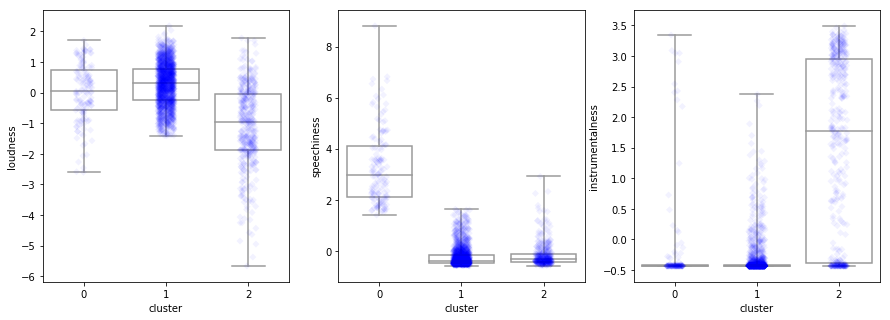

In [52]:
properties_cluster_simplified = properties_cluster[['cluster', 'loudness', 'speechiness', 'instrumentalness']]

plt.figure (figsize=(15,5))

for idx,col in enumerate(properties):
    plt.subplot(1,3,idx+1)
    ax = sns.boxplot(x='cluster', y=col, data=properties_cluster_simplified, whis=np.inf, color='white')
    ax = sns.stripplot(x='cluster', y=col, data=properties_cluster_simplified, color="blue",alpha=.05, marker='D', edgecolor="black")


In [53]:
properties_cluster[properties_cluster['cluster']==0].head(10)

cluster                                           name  \
73         0                                        Veneers   
197        0                                          Sundo   
265        0                                    Dear Laarni   
334        0                                        Creeper   
336        0                                          Slick   
341        0  On Wednesdays We Wear Pink (Extended Version)   
342        0                                      Go Online   
365        0                                      Manlalako   
375        0                                        B T T R   
652        0                                Hayaang Maidlip   

            artist_name                      id  loudness  speechiness  \
73     B. P. Valenzuela  0wgAHIBpHWMSWcg5HBcypr -0.307243     1.887068   
197        Johnoy Danao  6MdqkJK8Zrnas7zVzz9bHM -0.250105     1.538940   
265      BennyBunnyBand  4aBVF0EUGa1I7VJpxs0y1Q  0.306345     3.612572   
334     Reese Lansangan  5RItN9kZq4RolfRrnRWEIo -0.911929     3.627708   
336     Reese Lansangan  0FvYeC4AIHyw0ZSdbqtrIy -1.723059     2.643868   
341     Reese Lansangan  1LmE1BhyjlaG1LRP5JxvMs  0.158475     4.445052   
342     Reese Lansangan  4t1o4zOPkZGBZObqiV5PlF -2.602237     6.670043   
365        Bullet Dumas  43INOli7836sC6eQJMItTU  0.724112     2.204924   
375  Jensen & The Flips  0T48jE8N07DGX7wFVZzfz6  0.061139     3.143356   
652       Join The Club  6UFA38F1YIOR1Ymhx2rPGz  0.529728     1.887068   

     instrumentalness  
73          -0.434775  
197         -0.434914  
265         -0.434914  
334         -0.434914  
336         -0.434896  
341         -0.434914  
342         -0.434889  
365         -0.434914  
375         -0.433057  
652         -0.434914

In [54]:
properties_cluster[properties_cluster['cluster']==1].head(10)

cluster                                   name      artist_name  \
0         1  Away from the Current (Piano Version)  Keiko Necesario   
1         1                                 Blithe  Keiko Necesario   
2         1                      Let Me Be The One  Keiko Necesario   
3         1                            Ikaw Pa Rin  Keiko Necesario   
4         1                              Panaginip  Keiko Necesario   
6         1              Maybe in Another Lifetime  Keiko Necesario   
7         1                              Paano Na?  Keiko Necesario   
8         1                             Di Bale Na  Keiko Necesario   
9         1                     While We Are Young  Keiko Necesario   
10        1                                Highway  Keiko Necesario   

                        id  loudness  speechiness  instrumentalness  
0   3kFDnFj6asUJsUPodsWT2o -1.006968    -0.427225         -0.434914  
1   1I4FVXxMHTy07BvPO1mVjA -0.300639    -0.238026         -0.434609  
2   2IFNR24j14O8IuqLxFr0NT -0.237184    -0.304624         -0.434914  
3   4FrzR2A8kmSKB87Nx2oZjR  0.151871    -0.528637         -0.434910  
4   2vqAmth0yZZbBxwmVdE9V2  0.615292    -0.567990         -0.434813  
6   23GURsZ8hfMKVjUpm16IMq -1.286054    -0.395440         -0.434853  
7   06AxnsCACcLbrkVVCA6UCv -1.100283    -0.340950         -0.434914  
8   6b5pWdPQy9i85vBZR3pl2T -0.013800    -0.304624         -0.433857  
9   54Xd504CFfd9jWTcpNPg2U  0.322711    -0.206240         -0.434884  
10  0ghwbO2V01fXhpMMwx0sw1 -0.365242     0.514234         -0.434674

In [55]:
properties_cluster[properties_cluster['cluster']==2].head(10)

cluster                                name       artist_name  \
5         2                          Connection   Keiko Necesario   
34        2      Padayon - Instrumental Version        Ebe Dancel   
56        2                            Buhangin          Sandwich   
61        2                       Bato-Bato Pik          Sandwich   
64        2                          Time Lapse          Sandwich   
65        2  Even If You Asked Me (Coke Studio)          Sandwich   
68        2                          Pretty Car  B. P. Valenzuela   
83        2                            Geomorph  B. P. Valenzuela   
84        2                            Building  B. P. Valenzuela   
85        2                    All That You Are  B. P. Valenzuela   

                        id  loudness  speechiness  instrumentalness  
5   39fNON9tzWSkuLbpGAHJnD -1.730811    -0.431766         -0.434888  
34  3XGyrEUztdYjXmYVhmgJdh -1.031086    -0.425712          2.138964  
56  0QWD8Z9bHu1VdmyHTU6A1N  0.419759    -0.465065          1.556871  
61  5XbtjwIF3L8dA5wnCqta5w -0.184640    -0.188077          2.697297  
64  6ukXdujmXhceBsUO5xBB5c -0.321312    -0.548313          1.628148  
65  1YZnyCK0M97uf5isT2rgLk  0.314958    -0.489283          2.641860  
68  0VpKdv4sqfyhgZmdJ0HRzw -0.454538    -0.381817          1.940973  
83  0yK5vLL5SnyYzins78unhl -3.357090    -0.250134          2.835891  
84  72m5i3JNCqKsF4m5wMlqR0 -4.154151     0.645917         -0.327207  
85  7xV0WC2SwjkWu4fuxlYwCC -4.630492     0.163078          3.164555

In [56]:
properties_cluster[properties_cluster['artist_name']=='Reese Lansangan'].head(10)

cluster                                           name      artist_name  \
332        1                              Exploration No. 5  Reese Lansangan   
333        1                                   Grammar Nazi  Reese Lansangan   
334        0                                        Creeper  Reese Lansangan   
335        2                                    Code of Kin  Reese Lansangan   
336        0                                          Slick  Reese Lansangan   
337        1                                          Bleed  Reese Lansangan   
338        1                             A Song About Space  Reese Lansangan   
339        1                                      Autopilot  Reese Lansangan   
340        2                                  St.Petersburg  Reese Lansangan   
341        0  On Wednesdays We Wear Pink (Extended Version)  Reese Lansangan   

                         id  loudness  speechiness  instrumentalness  
332  2M3L8fORMZJ7f0EX7lb3Lq -0.434152     0.064694         -0.434914  
333  56z4qzBVFmm0wPZ3iXJGwD -0.521726     0.585373         -0.434914  
334  5RItN9kZq4RolfRrnRWEIo -0.911929     3.627708         -0.434914  
335  2bP0kjNitdIuvX0lRZqSRP -1.518625    -0.230458         -0.318496  
336  0FvYeC4AIHyw0ZSdbqtrIy -1.723059     2.643868         -0.434896  
337  6qqCJTqTtQlV74a9kMg4Te  0.237434    -0.024608         -0.434914  
338  76PZGcK7YmA7X9gH9VTD6U -0.918820     0.676189         -0.434914  
339  08wzTUWlKJthkECOrxR6N9  0.700281    -0.313705         -0.434914  
340  54dTQ3pMnujNESuOgHopAR -1.443398    -0.221376         -0.397455  
341  1LmE1BhyjlaG1LRP5JxvMs  0.158475     4.445052         -0.434914

### Other Features

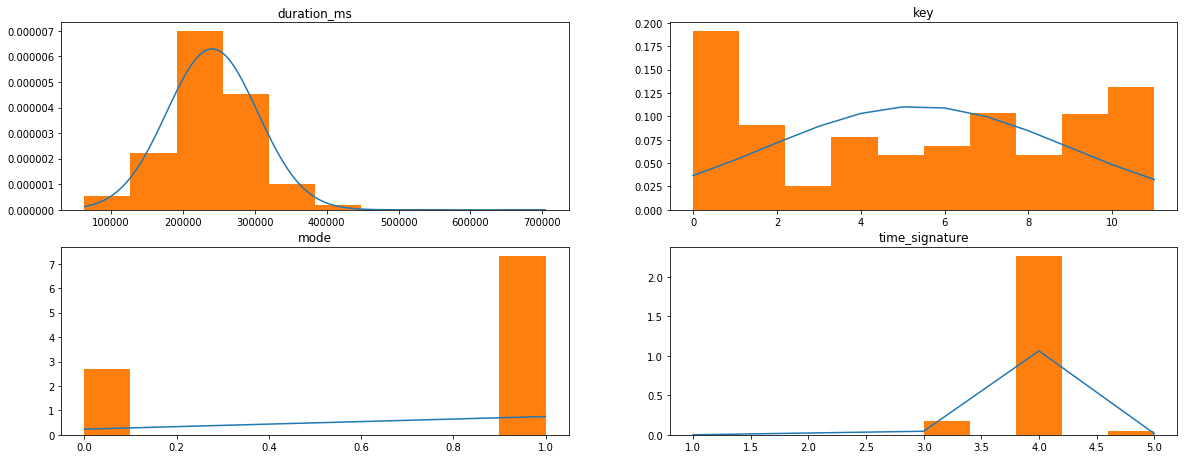

In [57]:
plt.figure(figsize=(20,20))
for idx, column in enumerate(data[['duration_ms','key','mode','time_signature']]):
    h = sorted(data[column])  #sorted
    fit = stats.norm.pdf(h, np.mean(h), np.std(h))
    
    plt.subplot(5,2,idx+1)
    plt.plot(h,fit)
    plt.title(column)
    plt.hist(h,density=True) 

     #use this to draw histogram of your data
plt.show()

In [58]:
data[['duration_ms','key','mode', 'time_signature']].describe()

duration_ms          key         mode  time_signature
count    2276.000000  2276.000000  2276.000000     2276.000000
mean   240770.905975     5.357206     0.731107        3.927944
std     63407.770266     3.605039     0.443482        0.368056
min     63000.000000     0.000000     0.000000        1.000000
25%    202871.250000     2.000000     0.000000        4.000000
50%    238997.500000     6.000000     1.000000        4.000000
75%    275344.500000     9.000000     1.000000        4.000000
max    704453.000000    11.000000     1.000000        5.000000

Songs are 4 minutes long on average. Nothing new here, because even typical songs outside our dataset are 3-5 minutes long.

For key, integers map to pitches using standard Pitch Class notation: https://en.wikipedia.org/wiki/Pitch_class. C is the most used key. 

Mode refers to track modality. Most tracks fall under 1 (major tracks). 

Most tracks also use the typical time signature of 4 beats. 

Overall, there's nothing surprising when we look at the above features. These are the characteristics of most songs.

# Examining Popularity

In [59]:
artists_top = artists.sort_values(by=['popularity'], ascending=False)

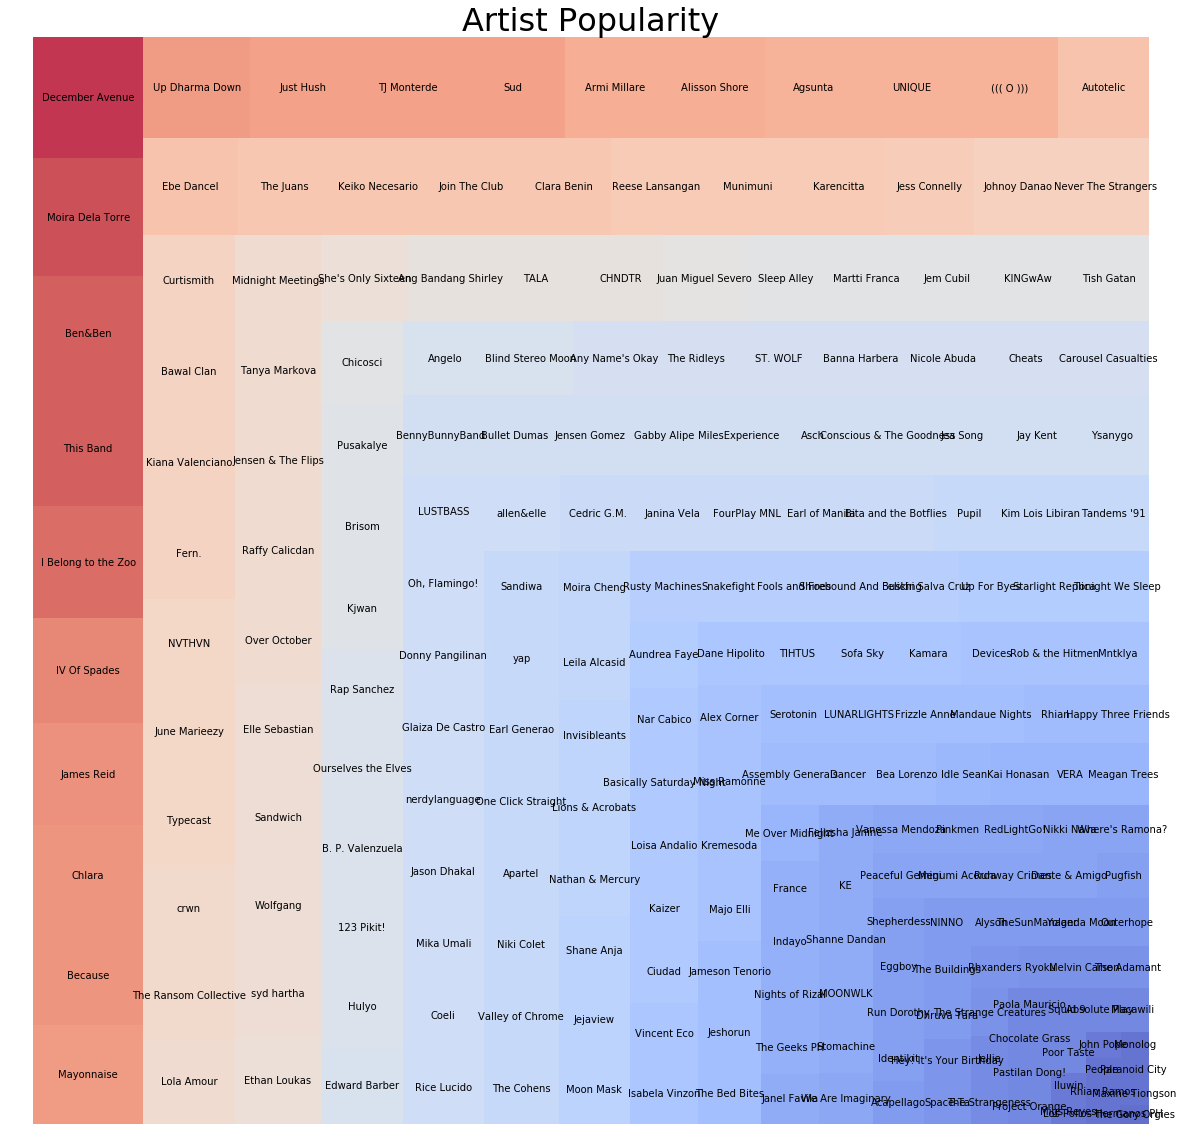

In [60]:
plt.figure(figsize=(20,20), facecolor='white')
cmap = matplotlib.cm.coolwarm
mini = min(artists_top["popularity"])
maxi = max(artists_top["popularity"])
# Finding Colors for each tile
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in artists_top["popularity"]]
# Plotting
squarify.plot(sizes=artists_top["popularity"], label=artists_top["artist_name"], alpha=0.8, color=colors)
# Removing Axis
plt.axis('off')
# Invert Y-Axis
plt.gca().invert_yaxis()
# Title
plt.title("Artist Popularity", fontsize=32)
# Title Positioning
ttl = ax.title
ttl.set_position([.5, 1.05])

There's no few artists dominating in terms of popularity. The values for popularity only decrease gradually.

In [61]:
artists_top['popularity %'] =( artists_top['popularity'] / sum(artists_top['popularity'])) *100

Text(0.5, 0, 'cumulative % of artist population')

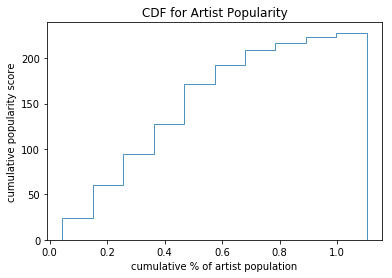

In [62]:
plt.hist(artists_top['popularity %'], cumulative=True, label='CDF', histtype='step', alpha=0.8)
plt.title("CDF for Artist Popularity")

plt.ylabel("cumulative popularity score")
plt.xlabel("cumulative % of artist population")

As you can see, the popularity distribution is almost linear. The most popular artists don't really take up a large chunk of the pupularity. The least popular ones, however, have very little popularity to go around.

In [63]:
artists_ranked = (artists.sort_values(by=['popularity'], ascending=False).head(10).artist_name).tolist()

popular = pd.DataFrame()
for artist in artists_ranked:
    popular = popular.append(data[data.artist_name == artist ])

len(popular)

267

In [64]:
Y_nosample = data[~data['artist_name'].isin(artists_ranked)]
Y_nosample.shape

(2009, 25)

In [65]:
col = ['acousticness','danceability','energy','instrumentalness','speechiness','valence','loudness','tempo']
Y_nosample = Y_nosample[col]
Y_nosample.shape

(2009, 8)

In [66]:
Y_sample = popular[col]
Y_sample.shape

(267, 8)

What are the popular songs like? Do they differ from the rest of the indie tracks?

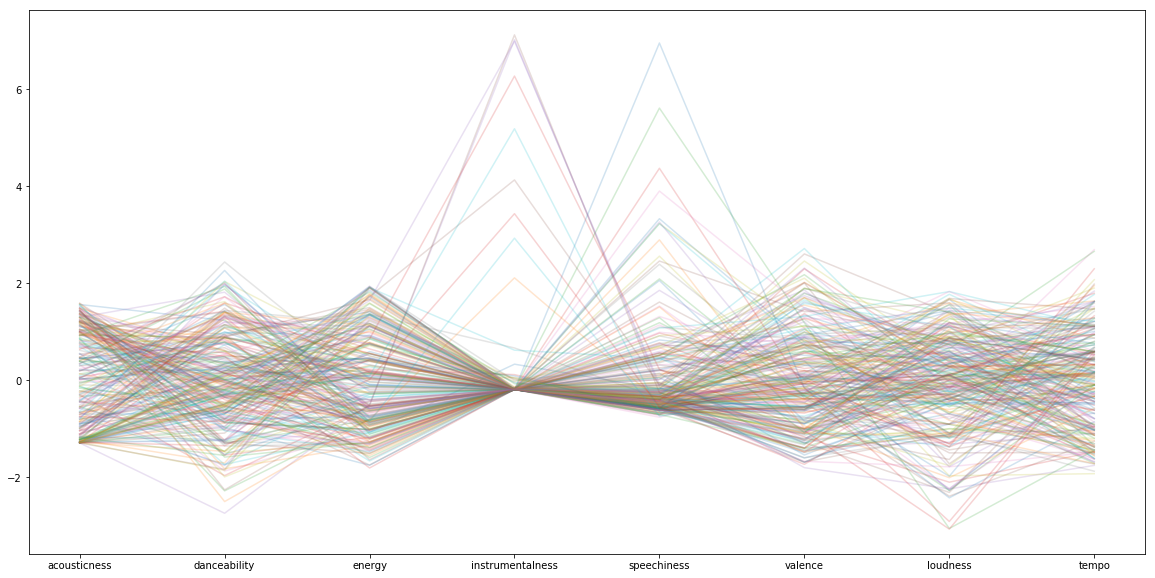

In [67]:
scaler = StandardScaler()
Y_sample = pd.DataFrame(scaler.fit_transform(Y_sample), columns = col)
Y_nosample = pd.DataFrame(scaler.fit_transform(Y_nosample), columns = col)

plt.figure(figsize=(20,10))
line = plt.plot(Y_sample.columns, Y_sample.T,alpha=0.2)

In [68]:
#check for meaningful difference (t-test?) between the top 10 features and all the tracks
#Null hypothesis: There is no significant difference between popular songs and the rest in terms of the features.
# alpha is 5% or 0.05
Y_sample.describe()

acousticness  danceability        energy  instrumentalness  \
count  2.670000e+02  2.670000e+02  2.670000e+02      2.670000e+02   
mean   1.368028e-16  2.449144e-16 -1.074879e-16     -2.502160e-16   
std    1.001878e+00  1.001878e+00  1.001878e+00      1.001878e+00   
min   -1.296635e+00 -2.746519e+00 -1.812536e+00     -1.936625e-01   
25%   -1.035710e+00 -6.572484e-01 -8.293050e-01     -1.936625e-01   
50%    2.093113e-02 -5.457424e-02 -1.128910e-01     -1.936531e-01   
75%    9.932164e-01  7.824732e-01  8.157159e-01     -1.932107e-01   
max    1.586886e+00  2.436479e+00  1.937608e+00      7.121667e+00   

        speechiness       valence      loudness         tempo  
count  2.670000e+02  2.670000e+02  2.670000e+02  2.670000e+02  
mean  -2.856641e-16 -3.991813e-17 -4.948185e-17  1.272390e-16  
std    1.001878e+00  1.001878e+00  1.001878e+00  1.001878e+00  
min   -7.653709e-01 -1.805524e+00 -3.073379e+00 -1.930075e+00  
25%   -5.237026e-01 -7.797601e-01 -5.033648e-01 -9.124057e-01  
50%   -3.558774e-01 -1.207229e-01  9.183611e-02  7.043867e-02  
75%    1.207461e-01  7.280004e-01  7.474268e-01  6.676320e-01  
max    6.954588e+00  2.714840e+00  1.828372e+00  2.691138e+00

Null hypothesis: There is no significant difference between tracks of popular artist and the rest of the population

critical value = 0.1

In [69]:
stats.ttest_ind(Y_nosample,Y_sample,equal_var = False)

Ttest_indResult(statistic=array([-2.17317835e-15,  9.59980630e-15, -3.77484631e-15, -2.93000266e-16,
        1.63142223e-15,  2.57604737e-15,  2.07531281e-15, -1.82700105e-15]), pvalue=array([1., 1., 1., 1., 1., 1., 1., 1.]))

We accept the null hypothesis.

There is no significant difference between tracks of 10 most popular musicians and the rest for all features.

What about the popular songs of the artists?

In [70]:
top_tracks.sort_values(by=['popularity'], ascending=False).head().T

813   \
artist_id                                    7tKpXx21KVUOR6vvDs6xtg   
external_url      https://open.spotify.com/track/1X4l4i472kW5ofF...   
id                                           1X4l4i472kW5ofFP8Xo0x0   
image_300         https://i.scdn.co/image/84a3e19ef4dd270946c501...   
image_64          https://i.scdn.co/image/cf16e1eaa5b71b70c2c740...   
image_640         https://i.scdn.co/image/a311c46653a6db396e2f9a...   
name                                                           Sana   
popularity                                                       72   
preview_url       https://p.scdn.co/mp3-preview/2b67ae5b1d2b0e73...   
artist_name                                     I Belong to the Zoo   
album_name                                                     Sana   
release_date                                                   2018   
acousticness                                                  0.701   
danceability                                                   0.66   
duration_ms                                                  277099   
energy                                                        0.373   
instrumentalness                                                  0   
key                                                               7   
loudness                                                     -7.874   
mode                                                              1   
speechiness                                                   0.029   
tempo                                                       126.887   
time_signature                                                    4   
valence                                                       0.348   

                                                               434   \
artist_id                                    5HIZU0JzM0AgfItVOm4E08   
external_url      https://open.spotify.com/track/2RgD3eO4IIGF16r...   
id                                           2RgD3eO4IIGF16rR8Ch8OV   
image_300         https://i.scdn.co/image/d8f99dd0b487ce372980da...   
image_64          https://i.scdn.co/image/407c122530dcc204370900...   
image_640         https://i.scdn.co/image/c0518e66609d54afdc189a...   
name                                                   Hindi Na Nga   
popularity                                                       72   
preview_url       https://p.scdn.co/mp3-preview/cd1f1284fe0e33bb...   
artist_name                                               This Band   
album_name                                             Hindi Na Nga   
release_date                                                   2018   
acousticness                                                 0.0877   
danceability                                                  0.396   
duration_ms                                                  282442   
energy                                                        0.413   
instrumentalness                                           2.95e-05   
key                                                               7   
loudness                                                    -11.566   
mode                                                              1   
speechiness                                                  0.0334   
tempo                                                       136.818   
time_signature                                                    4   
valence                                                       0.108   

                                                               1248  \
artist_id                                    4DAcJXcjX0zlQAZAPAx4Zb   
external_url      https://open.spotify.com/track/1yDiru08Q6omDOG...   
id                                           1yDiru08Q6omDOGkZMPnei   
image_300         https://i.scdn.co/image/e9427f75f16380a9447a64...   
image_64          https://i.scdn.co/image/71564475399ac06f3b9d03...   
image_640         https://i.scdn.co/image/dab6485cfa82f28b2718f3...   
name          

In [71]:
top_nine = top_tracks[top_tracks['popularity'] >= 70].sort_values(by=['popularity'], ascending=False)

Spotify measures track popularity based on the total number of plays and how recent those plays are. 

For now, let's look at the 9 most popular tracks. 

In [72]:
top_nine['popularity']

434     72.0
813     72.0
1152    71.0
1248    71.0
435     70.0
436     70.0
1153    70.0
1154    70.0
1155    70.0
Name: popularity, dtype: float64

In [73]:
top_nine.iloc[0]

artist_id                                      5HIZU0JzM0AgfItVOm4E08
external_url        https://open.spotify.com/track/2RgD3eO4IIGF16r...
id                                             2RgD3eO4IIGF16rR8Ch8OV
image_300           https://i.scdn.co/image/d8f99dd0b487ce372980da...
image_64            https://i.scdn.co/image/407c122530dcc204370900...
image_640           https://i.scdn.co/image/c0518e66609d54afdc189a...
name                                                     Hindi Na Nga
popularity                                                         72
preview_url         https://p.scdn.co/mp3-preview/cd1f1284fe0e33bb...
artist_name                                                 This Band
album_name                                               Hindi Na Nga
release_date                                                     2018
acousticness                                                   0.0877
danceability                                                    0.396
duration_ms         

Hindi Na Nga by This Band is a pop "hugot" song.

In [74]:
top_nine.iloc[1]

artist_id                                      7tKpXx21KVUOR6vvDs6xtg
external_url        https://open.spotify.com/track/1X4l4i472kW5ofF...
id                                             1X4l4i472kW5ofFP8Xo0x0
image_300           https://i.scdn.co/image/84a3e19ef4dd270946c501...
image_64            https://i.scdn.co/image/cf16e1eaa5b71b70c2c740...
image_640           https://i.scdn.co/image/a311c46653a6db396e2f9a...
name                                                             Sana
popularity                                                         72
preview_url         https://p.scdn.co/mp3-preview/2b67ae5b1d2b0e73...
artist_name                                       I Belong to the Zoo
album_name                                                       Sana
release_date                                                     2018
acousticness                                                    0.701
danceability                                                     0.66
duration_ms         

Sana by I Belong to the Zoo is an acoustic pop song with lyrics also about heartbreak.

In [75]:
top_nine.iloc[2]

artist_id                                      4qFxP3qN9GsnZDOkAE6x2m
external_url        https://open.spotify.com/track/2BgD4nRyx9EZ5o8...
id                                             2BgD4nRyx9EZ5o8YEnjRSV
image_300           https://i.scdn.co/image/eb376b5b1d3c4727ff4586...
image_64            https://i.scdn.co/image/7510ece15fedaded0a5596...
image_640           https://i.scdn.co/image/6e0fcdfaf773fb8ce47b4b...
name                                           Kung 'Di Rin Lang Ikaw
popularity                                                         71
preview_url         https://p.scdn.co/mp3-preview/19ae661dea5372b7...
artist_name                                           December Avenue
album_name                                     Kung 'Di Rin Lang Ikaw
release_date                                                     2018
acousticness                                                    0.161
danceability                                                    0.502
duration_ms         

 Kung 'Di Rin Lang Ikaw by December Avenue yet another song about heartbreak.

In [76]:
top_nine.iloc[3]

artist_id                                      4DAcJXcjX0zlQAZAPAx4Zb
external_url        https://open.spotify.com/track/1yDiru08Q6omDOG...
id                                             1yDiru08Q6omDOGkZMPnei
image_300           https://i.scdn.co/image/e9427f75f16380a9447a64...
image_64            https://i.scdn.co/image/71564475399ac06f3b9d03...
image_640           https://i.scdn.co/image/dab6485cfa82f28b2718f3...
name                                                  Maybe The Night
popularity                                                         71
preview_url         https://p.scdn.co/mp3-preview/1c14ab24c9add31f...
artist_name                                                   Ben&Ben
album_name                                            Maybe The Night
release_date                                                     2017
acousticness                                                    0.113
danceability                                                    0.572
duration_ms         

Maybe The Night by Ben&Ben is a love song that was used in the film Exes Baggage and a CloseUp ad, which likely aided its popularity.

In [77]:
top_nine.iloc[4]

artist_id                                      5HIZU0JzM0AgfItVOm4E08
external_url        https://open.spotify.com/track/58grXgbCj7t5ulr...
id                                             58grXgbCj7t5ulr0TGLIr9
image_300           https://i.scdn.co/image/db450749480c5d35a85b4b...
image_64            https://i.scdn.co/image/df8157af631d344eaa6bc7...
image_640           https://i.scdn.co/image/6a1f6f99e8ba9f98d3538f...
name                                                 Kahit Ayaw Mo Na
popularity                                                         70
preview_url         https://p.scdn.co/mp3-preview/1dbe606aa34cd8fa...
artist_name                                                 This Band
album_name                                           Kahit Ayaw Mo Na
release_date                                                     2018
acousticness                                                    0.341
danceability                                                    0.662
duration_ms         

Kahit Ayaw Mo Na is another song by This Band. It's thematically similar to Hindi Na Nga.

In [78]:
top_nine.iloc[5]

artist_id                                      5HIZU0JzM0AgfItVOm4E08
external_url        https://open.spotify.com/track/7hoP5NDUXEbmOaw...
id                                             7hoP5NDUXEbmOawvEAsi8h
image_300           https://i.scdn.co/image/179fb42ff7584a3e5619ac...
image_64            https://i.scdn.co/image/f7108f50ee31b4c5badc41...
image_640           https://i.scdn.co/image/ef2627919d10458fc2d152...
name                                                   'Di Na Babalik
popularity                                                         70
preview_url         https://p.scdn.co/mp3-preview/26eb4bba8d4e97b7...
artist_name                                                 This Band
album_name                                             'Di Na Babalik
release_date                                                     2019
acousticness                                                  0.00819
danceability                                                    0.358
duration_ms         

'Di Na Babalik is yet another song of heartbreak by This Band. 

In [79]:
top_nine.iloc[6]

artist_id                                      4qFxP3qN9GsnZDOkAE6x2m
external_url        https://open.spotify.com/track/6BxJLJw228OY5BF...
id                                             6BxJLJw228OY5BFerPGl7z
image_300           https://i.scdn.co/image/9f67bee339fb7781cb1e52...
image_64            https://i.scdn.co/image/7e7ac1b30d14fd2ae35066...
image_640           https://i.scdn.co/image/d8845b013badbe791f5211...
name                                                            Dahan
popularity                                                         70
preview_url         https://p.scdn.co/mp3-preview/cc1d02233bdf4426...
artist_name                                           December Avenue
album_name                                                      Dahan
release_date                                                     2019
acousticness                                                    0.318
danceability                                                    0.516
duration_ms         

Dahan by December Avenue is another "hugot" song about letting go.

In [80]:
top_nine.iloc[7]

artist_id                                      4qFxP3qN9GsnZDOkAE6x2m
external_url        https://open.spotify.com/track/24ngpWhBOxKJtIP...
id                                             24ngpWhBOxKJtIPnzSNX8c
image_300           https://i.scdn.co/image/120f1fa2f821eac040ab20...
image_64            https://i.scdn.co/image/d0541fb7a1f93f49883474...
image_640           https://i.scdn.co/image/a7b42a7b13dd0bb7db5b13...
name                Huling Sandali (Tayo Sa Huling Buwan Ng Taon O...
popularity                                                         70
preview_url         https://p.scdn.co/mp3-preview/861fcd85dfd44d31...
artist_name                                           December Avenue
album_name          Huling Sandali (Tayo Sa Huling Buwan Ng Taon O...
release_date                                                     2019
acousticness                                                   0.0208
danceability                                                    0.465
duration_ms         

Huling Sandali by December Avenue is part of the movie soundtrack for Tayo Sa Huling Buwan Ng Taon. It also counts as a feelsy hugot song.

In [81]:
top_nine.iloc[8]

artist_id                                      4qFxP3qN9GsnZDOkAE6x2m
external_url        https://open.spotify.com/track/5nMKJJ5Rl6X1yn5...
id                                             5nMKJJ5Rl6X1yn58aVeICO
image_300           https://i.scdn.co/image/7349e39d4af38680426f55...
image_64            https://i.scdn.co/image/a127d1cc34a9a48b1cff29...
image_640           https://i.scdn.co/image/18e1d5d00272c0c017f9e2...
name                                                           Bulong
popularity                                                         70
preview_url         https://p.scdn.co/mp3-preview/5d790300eeab3fed...
artist_name                                           December Avenue
album_name                                                     Bulong
release_date                                                     2018
acousticness                                                   0.0319
danceability                                                      0.5
duration_ms         

Bulong by December Avenue is about longing.

Hugot* count: 8/9 

I'm sensing a pattern here. Of course, it could be that most songs are produced are just hugot songs. To find out, we'll have to first classify whether a song was a hugot song or not, and then see if there is a statistically significant difference in terms of popularity for hugot and non-hugot songs. This topic can be explored in a different project since there are too many songs to manually classify (about 2,600) and not enough time. 


*Hugot songs are defined here as songs about heartbreak. It can take various forms: breaking up with someone, unrequited love, star-crossed lovers, etc. so long as that element of failed romance is involved.

In [82]:
top_nine_features = top_nine[['acousticness','danceability','energy','instrumentalness',
                              'loudness','speechiness','tempo','valence','mode','key','time_signature']]

top_nine_features.describe()

acousticness  danceability    energy  instrumentalness   loudness  \
count      9.000000      9.000000  9.000000          9.000000   9.000000   
mean       0.198066      0.514556  0.511444          0.000136  -7.338667   
std        0.224620      0.104634  0.105879          0.000307   2.219810   
min        0.008190      0.358000  0.373000          0.000000 -11.566000   
25%        0.031900      0.465000  0.435000          0.000000  -8.539000   
50%        0.113000      0.502000  0.522000          0.000002  -7.265000   
75%        0.318000      0.572000  0.529000          0.000049  -5.472000   
max        0.701000      0.662000  0.728000          0.000936  -4.736000   

       speechiness       tempo   valence      mode        key  time_signature  
count     9.000000    9.000000  9.000000  9.000000   9.000000             9.0  
mean      0.031578  120.009111  0.268111  0.888889   6.111111             4.0  
std       0.003660   25.816959  0.147705  0.333333   3.218868             0.0  
min       0.025700   74.050000  0.108000  0.000000   2.000000             4.0  
25%       0.029000  126.887000  0.132000  1.000000   4.000000             4.0  
50%       0.031300  129.973000  0.295000  1.000000   7.000000             4.0  
75%       0.034900  134.877000  0.351000  1.000000   9.000000             4.0  
max       0.036700  139.867000  0.498000  1.000000  10.000000             4.0

In [83]:
top_track_cluster = pd.DataFrame()

for idx in range(9):
    top_track_cluster = top_track_cluster.append(clustered_data[clustered_data['id']== top_nine['id'].iloc[idx]])

top_track_cluster

cluster                      id  \
847       1.0  2RgD3eO4IIGF16rR8Ch8OV   
1468      1.0  1X4l4i472kW5ofFP8Xo0x0   
180       2.0  2BgD4nRyx9EZ5o8YEnjRSV   
2196      0.0  1yDiru08Q6omDOGkZMPnei   
846       0.0  58grXgbCj7t5ulr0TGLIr9   
842       2.0  7hoP5NDUXEbmOawvEAsi8h   
175       2.0  6BxJLJw228OY5BFerPGl7z   
174       2.0  24ngpWhBOxKJtIPnzSNX8c   
181       2.0  5nMKJJ5Rl6X1yn58aVeICO   

                                                   name          artist_name  \
847                                        Hindi Na Nga            This Band   
1468                                               Sana  I Belong to the Zoo   
180                              Kung 'Di Rin Lang Ikaw      December Avenue   
2196                                    Maybe The Night              Ben&Ben   
846                                    Kahit Ayaw Mo Na            This Band   
842                                      'Di Na Babalik            This Band   
175                                               Dahan      December Avenue   
174   Huling Sandali (Tayo Sa Huling Buwan Ng Taon O...      December Avenue   
181                                              Bulong      December Avenue   

      acousticness  danceability  energy  instrumentalness  speechiness  \
847          0.298         0.699   0.501           0.00002       0.0244   
1468         0.584         0.840   0.377           0.00000       0.0472   
180            NaN           NaN     NaN               NaN          NaN   
2196         0.327         0.510   0.535           0.10400       0.0311   
846            NaN           NaN     NaN               NaN          NaN   
842          0.252         0.568   0.812           0.00000       0.0317   
175          0.215         0.870   0.702           0.00176       0.0474   
174          0.217         0.653   0.505           0.10600       0.0259   
181            NaN           NaN     NaN               NaN          NaN   

      valence  loudness    tempo  
847     0.679    -6.293  104.999  
1468    0.655   -13.562  116.014  
180       NaN       NaN      NaN  
2196    0.302   -10.006   80.020  
846       NaN       NaN      NaN  
842     0.578    -4.719  151.956  
175     0.832    -5.906  108.970  
174     0.452    -9.655   95.978  
181       NaN       NaN      NaN

The spread of clusters is varied enough.

In [84]:
top_track_mood = pd.DataFrame()

for idx in range(9):
    top_track_mood = top_track_mood.append(mood_cluster[mood_cluster['id']== top_nine['id'].iloc[idx]])

top_track_mood

cluster                                               name  \
847         0                                       Hindi Na Nga   
1468        0                                               Sana   
180         0                             Kung 'Di Rin Lang Ikaw   
2196        1                                    Maybe The Night   
846         1                                   Kahit Ayaw Mo Na   
842         0                                     'Di Na Babalik   
175         0                                              Dahan   
174         2  Huling Sandali (Tayo Sa Huling Buwan Ng Taon O...   
181         2                                             Bulong   

              artist_name                      id  danceability   valence  \
847             This Band  2RgD3eO4IIGF16rR8Ch8OV     -1.169331 -1.401269   
1468  I Belong to the Zoo  1X4l4i472kW5ofFP8Xo0x0      0.645694 -0.306436   
180       December Avenue  2BgD4nRyx9EZ5o8YEnjRSV     -0.440571 -1.291786   
2196              Ben&Ben  1yDiru08Q6omDOGkZMPnei      0.040686  0.377834   
846             This Band  58grXgbCj7t5ulr0TGLIr9      0.659444  0.040261   
842             This Band  7hoP5NDUXEbmOawvEAsi8h     -1.430585 -1.255291   
175       December Avenue  6BxJLJw228OY5BFerPGl7z     -0.344320 -0.548212   
174       December Avenue  24ngpWhBOxKJtIPnzSNX8c     -0.694949 -1.360213   
181       December Avenue  5nMKJJ5Rl6X1yn58aVeICO     -0.454321 -0.292751   

        energy     tempo  
847  -0.644723  0.585056  
1468 -0.821968  0.236721  
180  -0.338975  0.482495  
2196 -0.161730 -1.616566  
846  -0.130713  0.261168  
842  -0.547238 -1.543539  
175  -0.130713  0.344964  
174   0.148448  0.692001  
181   0.751081  0.516974

Same with the mood clustering.

In [85]:
top_track_properties = pd.DataFrame()

for idx in range(9):
    top_track_properties = top_track_properties.append(properties_cluster[properties_cluster['id']== top_nine['id'].iloc[idx]])

top_track_properties

cluster                                               name  \
847         1                                       Hindi Na Nga   
1468        1                                               Sana   
180         1                             Kung 'Di Rin Lang Ikaw   
2196        1                                    Maybe The Night   
846         1                                   Kahit Ayaw Mo Na   
842         1                                     'Di Na Babalik   
175         1                                              Dahan   
174         1  Huling Sandali (Tayo Sa Huling Buwan Ng Taon O...   
181         1                                             Bulong   

              artist_name                      id  loudness  speechiness  \
847             This Band  2RgD3eO4IIGF16rR8Ch8OV -0.895850    -0.437821   
1468  I Belong to the Zoo  1X4l4i472kW5ofFP8Xo0x0  0.164217    -0.504419   
180       December Avenue  2BgD4nRyx9EZ5o8YEnjRSV  1.065217    -0.507446   
2196              Ben&Ben  1yDiru08Q6omDOGkZMPnei -0.186363    -0.387872   
846             This Band  58grXgbCj7t5ulr0TGLIr9 -0.026721    -0.412089   
842             This Band  7hoP5NDUXEbmOawvEAsi8h  0.339077    -0.415117   
175       December Avenue  6BxJLJw228OY5BFerPGl7z  0.531164    -0.554368   
174       December Avenue  24ngpWhBOxKJtIPnzSNX8c  1.016693    -0.499878   
181       December Avenue  5nMKJJ5Rl6X1yn58aVeICO  0.853893    -0.469606   

      instrumentalness  
847          -0.434798  
1468         -0.434914  
180          -0.434914  
2196         -0.434720  
846          -0.434091  
842          -0.431208  
175          -0.434914  
174          -0.434908  
181          -0.434914

For properties, they're all grouped under one cluster.


Let's look at the other popular songs.

In [86]:
top_60 = top_tracks[(top_tracks['popularity'] < 70) & (top_tracks['popularity'] >= 60)].sort_values(by=['popularity'], ascending=False)

In [87]:
top_60_cluster = pd.DataFrame()

for idx in range(9):
    top_60_cluster = top_60_cluster.append(clustered_data[clustered_data['id']== top_60['id'].iloc[idx]])

top_60_cluster

cluster                      id                   name  \
1467      1.0  5NXdUJ3Z2jhlp2u1cj6f7m            Balang Araw   
2197      1.0  3WUEs51GpcvlgU7lehLgLh           Kathang Isip   
2178      0.0  5l9g7py8RCblcvbZgGQgSd              Pagtingin   
184       2.0  00mBzIWv5gHOYxwuEJXjOG  Sa Ngalan Ng Pag-Ibig   
658       2.0  3vGkyQlCw8LklNip0ZUELC                 Nobela   
1453      0.0  4u8RkgV6P4TLi89SmlUtv8                  Mundo   
183       2.0  6GIzDc4xBUeYHwubWwTrhC       Kahit Di Mo Alam   
1476      1.0  0ztDBQdQmdVZvorSmIjMih                Tagpuan   
1483      1.0  0gDRtumoR9ZrvAlnniToMz            Ikaw At Ako   

              artist_name  acousticness  danceability  energy  \
1467  I Belong to the Zoo       0.63800         0.801   0.555   
2197              Ben&Ben       0.25800         0.661   0.768   
2178              Ben&Ben       0.21000         0.624   0.574   
184       December Avenue       0.00375         0.473   0.603   
658         Join The Club       0.55900         0.714   0.477   
1453         IV Of Spades       0.00075         0.470   0.405   
183       December Avenue       0.00425         0.390   0.804   
1476     Moira Dela Torre       0.73100         0.833   0.253   
1483     Moira Dela Torre           NaN           NaN     NaN   

      instrumentalness  speechiness  valence  loudness    tempo  
1467          0.001150       0.0697   0.3260    -8.999   94.981  
2197          0.000013       0.0283   0.4060    -7.383  130.010  
2178          0.000252       0.0283   0.3790    -9.268  104.987  
184           0.000053       0.0333   0.3550    -6.821  115.453  
658           0.002280       0.0344   0.5910    -9.487   59.998  
1453          0.324000       0.0282   0.0514    -8.387  129.659  
183           0.000029       0.0479   0.4520    -4.336  148.123  
1476          0.000000       0.2140   0.6500   -17.447   80.974  
1483               NaN          NaN      NaN       NaN      NaN

In [88]:
top_60_cluster = pd.DataFrame()

for idx in range(9):
    top_60_cluster = top_60_cluster.append(mood_cluster[mood_cluster['id']== top_60['id'].iloc[idx]])

top_60_cluster

cluster                   name          artist_name  \
1467        0            Balang Araw  I Belong to the Zoo   
2197        0           Kathang Isip              Ben&Ben   
2178        1              Pagtingin              Ben&Ben   
184         2  Sa Ngalan Ng Pag-Ibig      December Avenue   
658         2                 Nobela        Join The Club   
1453        1                  Mundo         IV Of Spades   
183         2       Kahit Di Mo Alam      December Avenue   
1476        0                Tagpuan     Moira Dela Torre   
1483        0            Ikaw At Ako     Moira Dela Torre   

                          id  danceability   valence    energy     tempo  
1467  5NXdUJ3Z2jhlp2u1cj6f7m     -0.296194 -0.279066 -0.742207  0.693334  
2197  3WUEs51GpcvlgU7lehLgLh     -0.516197 -0.548212 -1.083404  0.237913  
2178  5l9g7py8RCblcvbZgGQgSd      0.707570  0.491879 -0.613705 -0.880015  
184   00mBzIWv5gHOYxwuEJXjOG     -0.330569 -0.607515  0.897308  1.257209  
658   3vGkyQlCw8LklNip0ZUELC     -1.320583  0.423452 -0.099695  1.457139  
1453  4u8RkgV6P4TLi89SmlUtv8      0.955073  0.300283 -0.697896  0.697754  
183   6GIzDc4xBUeYHwubWwTrhC     -0.798076 -0.607515  0.396591  0.865520  
1476  0ztDBQdQmdVZvorSmIjMih     -0.000565 -0.557336 -1.938610  0.530689  
1483  0gDRtumoR9ZrvAlnniToMz     -0.832451 -0.224324 -0.901728  0.539703

In [89]:
top_60_cluster = pd.DataFrame()

for idx in range(9):
    top_60_cluster = top_60_cluster.append(properties_cluster[properties_cluster['id']== top_60['id'].iloc[idx]])

top_60_cluster

cluster                   name          artist_name  \
1467        1            Balang Araw  I Belong to the Zoo   
2197        1           Kathang Isip              Ben&Ben   
2178        1              Pagtingin              Ben&Ben   
184         1  Sa Ngalan Ng Pag-Ibig      December Avenue   
658         1                 Nobela        Join The Club   
1453        1                  Mundo         IV Of Spades   
183         1       Kahit Di Mo Alam      December Avenue   
1476        1                Tagpuan     Moira Dela Torre   
1483        1            Ikaw At Ako     Moira Dela Torre   

                          id  loudness  speechiness  instrumentalness  
1467  5NXdUJ3Z2jhlp2u1cj6f7m -0.240342    -0.492310         -0.434914  
2197  3WUEs51GpcvlgU7lehLgLh -0.038493    -0.487769         -0.434896  
2178  5l9g7py8RCblcvbZgGQgSd -0.005187    -0.560422         -0.434914  
184   00mBzIWv5gHOYxwuEJXjOG  1.303819    -0.486256         -0.434914  
658   3vGkyQlCw8LklNip0ZUELC  0.712053    -0.539232         -0.434914  
1453  4u8RkgV6P4TLi89SmlUtv8 -0.130373    -0.374249         -0.434880  
183   6GIzDc4xBUeYHwubWwTrhC  1.128385    -0.477174         -0.434821  
1476  0ztDBQdQmdVZvorSmIjMih  0.068892    -0.421171         -0.434914  
1483  0gDRtumoR9ZrvAlnniToMz  0.314384    -0.505933         -0.427826

The next batch of popular songs fall under the one cluster.

Is there a connection between song popularity and its cluster?

In [90]:
top_tracks_clustered = top_tracks.merge(clustered_data[['cluster','id']], on='id')

In [91]:
top_tracks_clustered = top_tracks_clustered.sort_values(by=['popularity'], ascending=False)

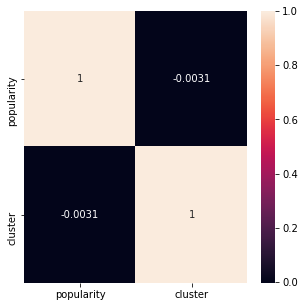

In [92]:
plt.figure(figsize=(5, 5))
corr = top_tracks_clustered[['popularity','cluster']].corr()
sns.heatmap(corr, 
            xticklabels=top_tracks_clustered[['popularity','cluster']].columns.values,
            yticklabels=top_tracks_clustered[['popularity','cluster']].columns.values,
            annot=True)

Looks like popularity and cluster have little correlation. It could just be that most songs fall under the second cluster.

In [93]:
top_tracks_clustered[['cluster','popularity']].groupby('cluster').describe()

popularity                                                   
             count       mean        std  min   25%   50%   75%   max
cluster                                                              
0.0          428.0  19.079439  15.788065  0.0   5.0  16.0  30.0  71.0
1.0          428.0  25.021028  16.935946  0.0  10.0  24.0  38.0  72.0
2.0          435.0  18.988506  15.223598  0.0   7.0  16.0  27.5  71.0

Yep, this is the case. The clustering count isn't vastly uneven, each cluster has a popular song, and the popularity means are close to each other.

Maybe we can find something with the properties clustering.

In [94]:
top_tracks_properties = top_tracks.merge(properties_cluster[['cluster','id']], on='id')
top_tracks_properties.columns

Index(['artist_id', 'external_url', 'id', 'image_300', 'image_64', 'image_640',
       'name', 'popularity', 'preview_url', 'artist_name', 'album_name',
       'release_date', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'valence', 'cluster'],
      dtype='object')

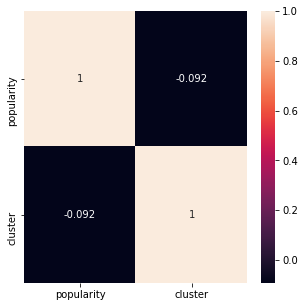

In [95]:
plt.figure(figsize=(5, 5))
corr = top_tracks_properties[['popularity','cluster']].corr()
sns.heatmap(corr, 
            xticklabels=top_tracks_properties[['popularity','cluster']].columns.values,
            yticklabels=top_tracks_properties[['popularity','cluster']].columns.values,
            annot=True)

No correlation, it looks like. 

In [96]:
top_tracks_properties[['cluster','popularity']].groupby('cluster').describe()

popularity                                                  
             count       mean        std  min  25%   50%   75%   max
cluster                                                             
0             78.0  16.525641  14.286243  0.0  5.0  10.5  27.0  51.0
1           1035.0  22.509179  16.309111  0.0  9.0  20.0  33.0  72.0
2            178.0  14.320225  14.486453  0.0  2.0   8.0  24.0  59.0

Are the popularity differences in each cluster statistically significant?

Our critical value is 0.05

In [97]:
properties_0 = top_tracks_properties['popularity'][top_tracks_properties['cluster']==0]
properties_1 = top_tracks_properties['popularity'][top_tracks_properties['cluster']==1]
properties_2 = top_tracks_properties['popularity'][top_tracks_properties['cluster']==2]

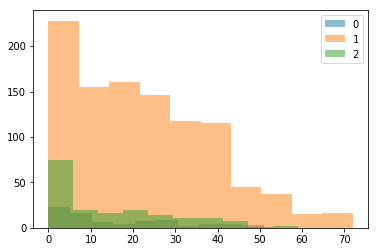

In [98]:
plt.hist(properties_0, label='0', alpha=0.5) 
plt.hist(properties_1, label='1', alpha=0.5)
plt.hist(properties_2, label='2', alpha=0.5) 
plt.legend()

To perform one way ANOVA, the population must usually be normally distributed in each group.

However, violations of normality are not usually a death sentence for validity. As long as the sample size exceeds 30 (even better if it is greater than 50), there is not usually too much of an impact to validity from non-normal data; something that Stevens stressed in his 2016 publication of Applied Multivariate Statistics for the Social Sciences.

In [99]:
#Let's test for homogeneity of variance
stats.levene(properties_0,properties_1,properties_2)

LeveneResult(statistic=2.3385690210918915, pvalue=0.0968750545675449)

We accept the null hypothesis that the variances are equal. 

In [100]:
stats.f_oneway(properties_0,properties_1,properties_2)

F_onewayResult(statistic=23.295213808228837, pvalue=1.1526573421962846e-10)

Looks like there's no statistically significant difference.

# Album Variation

Album variation will be measured based on how different its feature values are from all the other albums.

What we want to do is measure how each track deviates in distance from all the other tracks in the album.

To do this, we first perform PCA on the data then calculate the standard deviation per album. This will serve as the album track variation score.

In [101]:
reduced_data = pd.DataFrame(reduced_data)
reduced_data['id'] = data['id'].values
reduced_data['name'] = data['name'].values
reduced_data['artist_name'] = data['artist_name'].values
reduced_data['album_id'] = data['album_id'].values
reduced_data['album_name'] = data['album_name'].values
reduced_data['album_type'] = data['album_type'].values
reduced_data.head()

0         1                      id  \
0  2.728120  0.077825  3kFDnFj6asUJsUPodsWT2o   
1  0.290615 -0.897332  1I4FVXxMHTy07BvPO1mVjA   
2  2.284328 -0.011178  2IFNR24j14O8IuqLxFr0NT   
3  1.734308 -0.872133  4FrzR2A8kmSKB87Nx2oZjR   
4 -1.158518  1.114388  2vqAmth0yZZbBxwmVdE9V2   

                                    name      artist_name  \
0  Away from the Current (Piano Version)  Keiko Necesario   
1                                 Blithe  Keiko Necesario   
2                      Let Me Be The One  Keiko Necesario   
3                            Ikaw Pa Rin  Keiko Necesario   
4                              Panaginip  Keiko Necesario   

                 album_id                                         album_name  \
0  7Lnn2od0JUFPDM6H9RXPBQ              Away from the Current (Piano Version)   
1  5ekL2fwFPglRj6BvLLU26A                                             Blithe   
2  5lyZ3Wwa9YW6EFj8tKaxdd  Nakalimutan Ko Nang Kalimutan Ka (Official Mov...   
3  5lyZ3Wwa9YW6EFj8tKaxdd  Nakalimutan Ko Nang Kalimutan Ka (Official Mov...   
4  6fRKrRev7RcNBXCm326IXw  Ang Babaeng Allergic Sa Wifi (Original Motion ...   

  album_type  
0     single  
1     single  
2     single  
3     single  
4     single

In [102]:
to_highlight = reduced_data[reduced_data['album_id']=='4acHD3ykZw3DYLcLW1Mqv3']

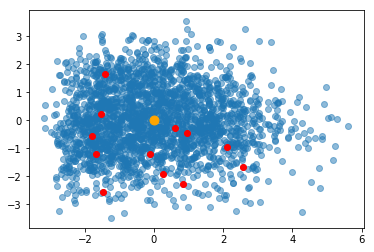

In [103]:
plt.scatter(reduced_data[0],reduced_data[1], alpha=0.5)
plt.scatter(to_highlight[0],to_highlight[1], color='red')
plt.scatter(reduced_data[0].mean(),reduced_data[1].mean(), color='orange', s=80)

In [104]:
#get rid of tracks that are singles
print(reduced_data.shape)
reduced_albums=reduced_data[reduced_data['album_type']=='album']
print(reduced_albums.shape)

(2276, 8)
(1166, 8)


In [105]:
#get the standard deviation per album
reduced_albums_std = reduced_albums.groupby('album_id').std().reset_index()
reduced_albums_std.head()

album_id         0         1
0  02txPZEr9smumnFaxOrdAt  1.416037  0.935363
1  05rQadwAVYTpNNnBoeTuj0  0.930931  1.215329
2  08nQUfuftB2KzgfTZNld8A  2.060924  1.144757
3  0A251v7CqF6LAx74bmqZks  1.004592  1.191143
4  0DWKo3p5bQSV3td2etejXJ  1.256164  1.006416

In [106]:
reduced_albums_std = reduced_albums[['album_id','artist_name','album_name']].drop_duplicates().merge(reduced_albums_std, on='album_id')
reduced_albums_std.head()

album_id       artist_name  \
0  4acHD3ykZw3DYLcLW1Mqv3        Ebe Dancel   
1  4bU263JJqschDhYZRgbnt7         Autotelic   
2  0oZlesVQj072lg8KM4ojFC          Sandwich   
3  46FVwz9NCaXlRWlBSx7LG4  B. P. Valenzuela   
4  2ccGiBe4kDrOdnRA0IMLlo        Mayonnaise   

                                        album_name         0         1  
0                                       Bawat Daan  1.526190  1.163761  
1                                  Papunta Pabalik  1.059590  0.603990  
2                                           Debris  0.753000  0.859348  
3                                        Neon Hour  0.699928  1.040265  
4  Gusto Ko Lang Kasama Ka Palagi Pero Hindi Pwede  2.009814  0.757762

In [107]:
#get distance from the origin (0,0) since a standard deviation of 0 means all tracks are equal to the mean  
reduced_albums_std['album_distance'] =[euclidean([reduced_albums_std.loc[x][0],reduced_albums_std.loc[x][1]],[0,0]) for x in range(len(reduced_albums_std))]

In [108]:
reduced_albums_std.sort_values(by='album_distance').head(10) #Albums with the most similar tracks

album_id            artist_name  \
30   4cx6CRSKWfQ90pSIbptsQh       Lions & Acrobats   
33   2KzwyXW4u2MewGOnioHyT0                  Pupil   
108  0ab6fhMmKWtTfczaxprpiy            Rap Sanchez   
32   7fy9ViwHRwWAEmG4upZLn9                 Cheats   
53   3SrqGYBJ6MaJ7QZu8yTZSN             Curtismith   
84   7i8cfv0rwUaJ0Q1KTTl7IM      Assembly Generals   
11   3LWiguQVKE7gAP1PsAyrwv  The Ransom Collective   
64   7z2DVbUC9iLaBZe8mTmmE1        Nights of Rizal   
76   13vapJJUG4b1an7XNR56Hz             123 Pikit!   
56   0EPue1OBoRjRYpgQ3wLreE             James Reid   

                             album_name         0         1  album_distance  
30   Points & Perspectives (Remastered)  0.428973  0.428889        0.606600  
33                                Zilch  0.480758  0.584191        0.756576  
108                             Emprise  0.512599  0.558462        0.758049  
32                               Cheats  0.596173  0.493453        0.773898  
53                        Soully, Yours  0.647097  0.531286        0.837258  
84                              Fatigue  0.595828  0.603836        0.848310  
11                               Traces  0.694012  0.546688        0.883471  
64                          summer/salt  0.720868  0.560329        0.913028  
76                            Taeng Aso  0.477798  0.797920        0.930036  
56                          Palm Dreams  0.532442  0.791625        0.954025

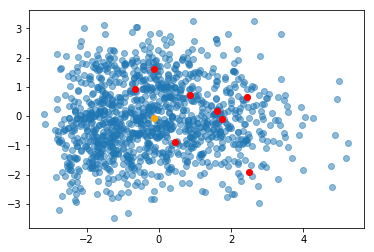

In [109]:
to_highlight = reduced_albums[reduced_albums['album_id']=='2mgoR6YKtUvawT9bAYwXjG']
plt.scatter(reduced_albums[0],reduced_albums[1], alpha=0.5)
plt.scatter(to_highlight[0],to_highlight[1], color='red')
plt.scatter(reduced_albums[0].mean(),reduced_albums[1].mean(), color='orange')

In [110]:
reduced_albums_std.sort_values(by='album_distance', ascending=False).head(10) #Albums with the least similar tracks

album_id       artist_name  \
75   1fhIqZTgAKsfEeNfzVHyZ6            lluwin   
97   4jZMhB0AgTzISkuSoy0nsd    Pastilan Dong!   
12   08nQUfuftB2KzgfTZNld8A   MilesExperience   
65   2tP8y1GDr7DNomBkcJI0H0           MOONWLK   
59   60qph1sDjhgZtPR4IEnu5Y            UNIQUE   
49   7dp1bIZwLjuQcSXbj9kICi           Monolog   
5    5p6vpvFIalvE294hauTVbp        Mayonnaise   
4    2ccGiBe4kDrOdnRA0IMLlo        Mayonnaise   
101  6P5nlUfWzOj8zHxRcZ772x  Glaiza De Castro   
52   4n7JDVgx22y8S3can1mSjk              crwn   

                                          album_name         0         1  \
75                                 Naritokanangapala  2.432659  1.007426   
97                                    Pastilan Dong!  2.262371  1.269597   
12                                         Soberhaul  2.060924  1.144757   
65                                        Of the Bed  2.267387  0.567890   
59                                           Grandma  1.869569  1.198463   
49                                   Rockstar Heaven  2.030305  0.867008   
5                            For The Rest Of My Life  1.901667  1.096691   
4    Gusto Ko Lang Kasama Ka Palagi Pero Hindi Pwede  2.009814  0.757762   
101                                 Glaiza Synthesis  1.803565  1.034645   
52                                            Orchid  1.561458  1.364661   

     album_distance  
75         2.633009  
97         2.594263  
12         2.357514  
65         2.337423  
59         2.220721  
49         2.207678  
5          2.195238  
4          2.147919  
101        2.079264  
52         2.073753

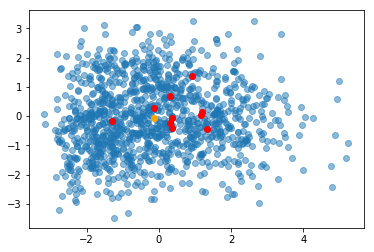

In [111]:
to_highlight = reduced_albums[reduced_albums['album_id']=='7CIc8keZ5tOKJMzYidj1qr']
plt.scatter(reduced_albums[0],reduced_albums[1], alpha=0.5)
plt.scatter(to_highlight[0],to_highlight[1], color='red')
plt.scatter(reduced_albums[0].mean(),reduced_albums[1].mean(), color='orange')

In [112]:
#What if the data wasn't reduced?
data.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy', 'id',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'name',
       'preview_url', 'album_id', 'album_type', 'artist_id', 'image_300',
       'image_64', 'image_640', 'album_name', 'release_date', 'artist_name'],
      dtype='object')

In [113]:
Y.head()

acousticness  danceability    energy  instrumentalness  speechiness  \
0      1.848494     -0.220568 -1.686036         -0.434914    -0.427225   
1     -0.354503     -0.351195 -0.130713         -0.434609    -0.238026   
2      1.798639      0.123187 -1.650587         -0.434914    -0.304624   
3      1.935742     -0.399320 -1.358133         -0.434910    -0.528637   
4     -0.525882      0.824447  0.511800         -0.434813    -0.567990   

    valence  loudness     tempo  
0 -0.525403 -1.006968 -0.883558  
1 -1.068257 -0.300639  0.255556  
2 -0.808235 -0.237184 -0.429785  
3 -0.748931  0.151871  0.703155  
4  1.135093  0.615292 -0.321752

In [114]:
uniqueness_data_nonpca = pd.DataFrame(Y)
uniqueness_data_nonpca['id'] = data['id']
uniqueness_data_nonpca['name'] = data['name']
uniqueness_data_nonpca['artist_name'] = data['artist_name']
uniqueness_data_nonpca['album_id'] = data['album_id']
uniqueness_data_nonpca['album_name'] = data['album_name']
uniqueness_data_nonpca['album_type'] = data['album_type']
uniqueness_data_nonpca = uniqueness_data_nonpca[uniqueness_data_nonpca['album_type']=='album']

In [115]:
uniqueness_data_nonpca.head()

acousticness  danceability    energy  instrumentalness  speechiness  \
18      1.798639     -1.623087 -1.854419         -0.434909    -0.454470   
19     -0.997018     -1.038704 -0.152868         -0.434893    -0.508960   
20     -0.335807      0.102562  0.848565         -0.434914    -0.452957   
21      1.306314     -0.358070 -1.597414         -0.434914    -0.463552   
22      0.390216      0.686945  1.384731         -0.434914     0.126752   

     valence  loudness     tempo                      id  \
18 -0.885785 -0.957869  0.547315  0wUSZjJVblGKntOqBSWMdo   
19 -1.460116  0.581124 -1.122808  1PylPQlmQ2ymbRFtEqs3NM   
20  1.212644  0.614430  0.839354  461EfHiwzh8ZCZGaFEIaAJ   
21 -0.771740 -1.030225  1.031462  4ZMMxYeUfDcTbJrYbHYkH9   
22  1.573026  0.920793 -0.811267  2FdFtKCpMUVSyjfrisntqS   

                                                 name artist_name  \
18                                         Bawat Daan  Ebe Dancel   
19                                            Kasayaw  Ebe Dancel   
20                                               Prom  Ebe Dancel   
21  Hanggang Wala Nang Bukas - Theme from Heneral ...  Ebe Dancel   
22                                        Dapit-Hapon  Ebe Dancel   

                  album_id  album_name album_type  
18  4acHD3ykZw3DYLcLW1Mqv3  Bawat Daan      album  
19  4acHD3ykZw3DYLcLW1Mqv3  Bawat Daan      album  
20  4acHD3ykZw3DYLcLW1Mqv3  Bawat Daan      album  
21  4acHD3ykZw3DYLcLW1Mqv3  Bawat Daan      album  
22  4acHD3ykZw3DYLcLW1Mqv3  Bawat Daan      album

In [116]:
uniqueness_data_nonpca_std = uniqueness_data_nonpca.groupby('album_id').std().reset_index()
uniqueness_data_nonpca_std = reduced_albums[['album_id','artist_name','album_name']].drop_duplicates().merge(uniqueness_data_nonpca_std, on='album_id')
uniqueness_data_nonpca_std.head()

album_id       artist_name  \
0  4acHD3ykZw3DYLcLW1Mqv3        Ebe Dancel   
1  4bU263JJqschDhYZRgbnt7         Autotelic   
2  0oZlesVQj072lg8KM4ojFC          Sandwich   
3  46FVwz9NCaXlRWlBSx7LG4  B. P. Valenzuela   
4  2ccGiBe4kDrOdnRA0IMLlo        Mayonnaise   

                                        album_name  acousticness  \
0                                       Bawat Daan      1.107535   
1                                  Papunta Pabalik      0.372821   
2                                           Debris      0.962215   
3                                        Neon Hour      1.162002   
4  Gusto Ko Lang Kasama Ka Palagi Pero Hindi Pwede      0.668162   

   danceability    energy  instrumentalness  speechiness   valence  loudness  \
0      0.767374  1.135346          0.001007     0.235314  1.007116  0.638386   
1      0.677218  0.820468          0.067273     0.284976  1.047987  0.561647   
2      1.077128  0.410268          0.742133     0.805866  0.719435  0.392893   
3      0.922444  1.522912          1.098758     0.287693  0.971936  2.181681   
4      0.652753  0.759453          1.288701     0.395488  1.004161  0.441043   

      tempo  
0  1.136439  
1  0.816911  
2  0.704016  
3  1.184976  
4  0.754973

In [117]:
uniqueness_data_nonpca_std['distance'] =[euclidean(uniqueness_data_nonpca_std.loc[x][col],np.zeros(8)) for x in range(len(uniqueness_data_nonpca_std))]
uniqueness_data_nonpca_std.head()

album_id       artist_name  \
0  4acHD3ykZw3DYLcLW1Mqv3        Ebe Dancel   
1  4bU263JJqschDhYZRgbnt7         Autotelic   
2  0oZlesVQj072lg8KM4ojFC          Sandwich   
3  46FVwz9NCaXlRWlBSx7LG4  B. P. Valenzuela   
4  2ccGiBe4kDrOdnRA0IMLlo        Mayonnaise   

                                        album_name  acousticness  \
0                                       Bawat Daan      1.107535   
1                                  Papunta Pabalik      0.372821   
2                                           Debris      0.962215   
3                                        Neon Hour      1.162002   
4  Gusto Ko Lang Kasama Ka Palagi Pero Hindi Pwede      0.668162   

   danceability    energy  instrumentalness  speechiness   valence  loudness  \
0      0.767374  1.135346          0.001007     0.235314  1.007116  0.638386   
1      0.677218  0.820468          0.067273     0.284976  1.047987  0.561647   
2      1.077128  0.410268          0.742133     0.805866  0.719435  0.392893   
3      0.922444  1.522912          1.098758     0.287693  0.971936  2.181681   
4      0.652753  0.759453          1.288701     0.395488  1.004161  0.441043   

      tempo  distance  
0  1.136439  2.423468  
1  0.816911  1.854074  
2  0.704016  2.149919  
3  1.184976  3.594302  
4  0.754973  2.244838

In [118]:
uniqueness_data_nonpca_std.sort_values(by='distance').head(10)

album_id          artist_name          album_name  \
10  6K9V6MxhxQqwPjoxbyc2rE         Johnoy Danao         Samu't-Sari   
58  1UeeX7O8uWEkBpgLpi1C5S              Because      Heartbreak SZN   
38  4gyd2janVls7J3lX6WXdta      Maxine Tiongson     Maxine Tiongson   
71  05rQadwAVYTpNNnBoeTuj0     Moira Dela Torre              Malaya   
7   6iR6ubr14wcuF9VafyvUVg                Kjwan        IV Volume II   
50  2Dn1TPXD4QDrWXUnTghXn0           Poor Taste           Pure Dirt   
68  4UeWZpXENQJXluB6CBg6ZW           Karencitta  Cebuana Persuasion   
22  2iwjSLyvZJAogsvnKpaCov  Never The Strangers          Screenburn   
1   4bU263JJqschDhYZRgbnt7            Autotelic     Papunta Pabalik   
31  4syrgMPfhuA65cjB33THKl               Cheats   Before the Babies   

    acousticness  danceability    energy  instrumentalness  speechiness  \
10      0.535360      0.778942  0.426098          0.074137     0.136642   
58      0.520129      0.701448  0.466539          0.000109     0.057489   
38      0.056836      0.873805  0.204860          0.073119     0.144112   
71      0.027016      0.742465  0.392250          0.002261     0.470209   
7       0.828259      0.548802  0.863109          0.000020     0.087306   
50      0.469474      0.923341  0.311219          0.057564     0.736855   
68      0.010691      0.659597  0.383330          0.000228     0.259174   
22      0.922879      0.755518  0.721335          0.004391     0.174085   
1       0.372821      0.677218  0.820468          0.067273     0.284976   
31      0.675916      0.871148  0.646001          0.000212     0.504083   

     valence  loudness     tempo  distance  
10  0.803437  0.419756  0.379282  1.436889  
58  0.452437  0.485327  0.815077  1.445033  
38  0.540975  0.570886  0.813951  1.454624  
71  0.613099  0.365442  1.080551  1.613683  
7   0.525575  0.424521  0.729234  1.651667  
50  0.569029  0.616286  0.714519  1.711792  
68  0.740376  0.569547  1.281399  1.778713  
22  0.868545  0.534728  0.616850  1.842273  
1   1.047987  0.561647  0.816911  1.854074  
31  0.875202  0.485703  0.748992  1.857432

In [119]:
uniqueness_data_nonpca_std.sort_values(by='distance', ascending=False).head(10)

album_id        artist_name            album_name  \
80   6K3zUrIHmP0p6fj5zUSNQe           Typecast     Campfire Sessions   
15   27jcbwKc8QCupGH2D0HXLX            Apartel  Inner Play (Remixes)   
79   5brVpbx6EHrmyoVb5dS2PY   Valley of Chrome            Dark Horse   
3    46FVwz9NCaXlRWlBSx7LG4   B. P. Valenzuela             Neon Hour   
64   7z2DVbUC9iLaBZe8mTmmE1    Nights of Rizal           summer/salt   
61   4WtiljJg8by8qPi5Hrgrcx   We Are Imaginary  Death to Romanticism   
56   0EPue1OBoRjRYpgQ3wLreE         James Reid           Palm Dreams   
100  3Lil4hR6tuUteKCy93VVBs   Glaiza De Castro    Magandang Simulain   
85   7qrkSYUV0iE6V0RsD7SWxQ  Assembly Generals     Assembly Generals   
33   2KzwyXW4u2MewGOnioHyT0              Pupil                 Zilch   

     acousticness  danceability    energy  instrumentalness  speechiness  \
80       1.042951      1.267197  1.024263          1.533881     2.316552   
15       0.772154      0.710521  0.744578          0.014156     2.818320   
79       0.991819      1.334995  1.707947          1.520873     1.302405   
3        1.162002      0.922444  1.522912          1.098758     0.287693   
64       1.197023      1.241763  1.236960          1.723315     0.247258   
61       1.019764      1.341450  0.731045          1.394331     2.089883   
56       1.300658      0.667543  1.260889          1.561642     0.823447   
100      1.171891      0.812299  0.837879          1.679423     1.389322   
85       1.043918      0.820479  0.555304          0.580387     2.248812   
33       0.766666      1.145460  0.762008          0.000067     2.235827   

      valence  loudness     tempo  distance  
80   1.319734  0.821954  1.468764  4.004551  
15   1.101773  1.145095  1.378191  3.744749  
79   0.643495  1.574304  1.054445  3.700904  
3    0.971936  2.181681  1.184976  3.594302  
64   0.733181  1.747547  1.100754  3.512691  
61   1.002422  0.479266  1.158025  3.501596  
56   0.776137  1.839628  0.474978  3.325084  
100  1.086313  1.031372  1.063794  3.295654  
85   0.950232  0.753762  1.341597  3.276629  
33   0.819947  0.957312  1.270348  3.268329

Both the PCA-reduced and non-PCA datasets share some albums that rank low in uniqueness. We'll go with the dataset that went through dimensionality reduction since computing distance gets unreliable in higher dimensions (curse of dimensionality). 

We could also try grouping the tracks by artists to measure how varied their songs are and see how artists evolve over time. However, this would require the artists whole discography, which is beyond the scope of this project. It's an interesting idea for a another project though.  

In [120]:
reduced_top_tracks = reduced_data.merge(top_tracks[['popularity','id']], on='id')
reduced_top_tracks.head()

0         1                      id  \
0  2.728120  0.077825  3kFDnFj6asUJsUPodsWT2o   
1  2.284328 -0.011178  2IFNR24j14O8IuqLxFr0NT   
2  2.284328 -0.011178  2IFNR24j14O8IuqLxFr0NT   
3  1.734308 -0.872133  4FrzR2A8kmSKB87Nx2oZjR   
4  1.734308 -0.872133  4FrzR2A8kmSKB87Nx2oZjR   

                                    name      artist_name  \
0  Away from the Current (Piano Version)  Keiko Necesario   
1                      Let Me Be The One  Keiko Necesario   
2                      Let Me Be The One  Keiko Necesario   
3                            Ikaw Pa Rin  Keiko Necesario   
4                            Ikaw Pa Rin  Keiko Necesario   

                 album_id                                         album_name  \
0  7Lnn2od0JUFPDM6H9RXPBQ              Away from the Current (Piano Version)   
1  5lyZ3Wwa9YW6EFj8tKaxdd  Nakalimutan Ko Nang Kalimutan Ka (Official Mov...   
2  5lyZ3Wwa9YW6EFj8tKaxdd  Nakalimutan Ko Nang Kalimutan Ka (Official Mov...   
3  5lyZ3Wwa9YW6EFj8tKaxdd  Nakalimutan Ko Nang Kalimutan Ka (Official Mov...   
4  5lyZ3Wwa9YW6EFj8tKaxdd  Nakalimutan Ko Nang Kalimutan Ka (Official Mov...   

  album_type  popularity  
0     single        28.0  
1     single        55.0  
2     single        55.0  
3     single        53.0  
4     single        53.0

In [121]:
reduced_top_tracks['popularity'].describe()

count    1291.00000
mean       21.01859
std        16.22878
min         0.00000
25%         7.00000
50%        19.00000
75%        32.00000
max        72.00000
Name: popularity, dtype: float64

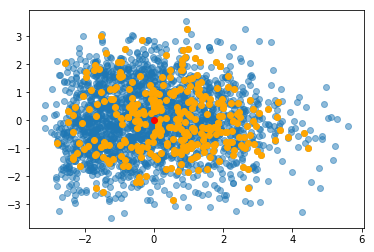

In [122]:
to_highlight = reduced_top_tracks[reduced_top_tracks['popularity'] >= 32] #32 for the 75th percentile
plt.scatter(reduced_data[0],reduced_data[1], alpha=0.5)
plt.scatter(to_highlight[0],to_highlight[1], color='orange')
plt.scatter(reduced_data[0].mean(),reduced_data[1].mean(), color='red')

The 25% most popular tracks don't seem to cluster in a particular area. It all looks spread out.

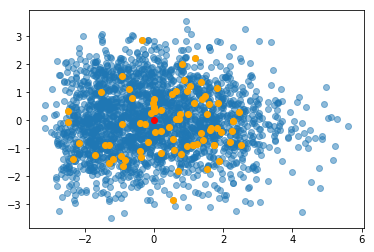

In [123]:
to_highlight = reduced_top_tracks[reduced_top_tracks['popularity'] >= 50] 
plt.scatter(reduced_data[0],reduced_data[1], alpha=0.5)
plt.scatter(to_highlight[0],to_highlight[1], color='orange')
plt.scatter(reduced_data[0].mean(),reduced_data[1].mean(), color='red')

No clear pattern here either.

In [124]:
#is there a correlation between album type and popularity?
enc = OneHotEncoder(handle_unknown='ignore')
output = enc.fit_transform(np.array(reduced_top_tracks['album_type']).reshape(-1,1))
reduced_top_tracks['album_type_onehot'] = np.zeros(len(reduced_top_tracks))
reduced_top_tracks['album_type_onehot'] = output.toarray()

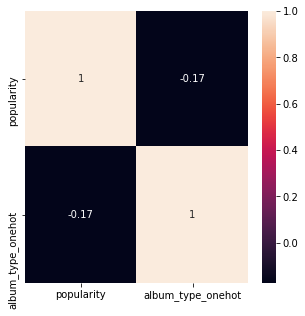

In [125]:
plt.figure(figsize=(5, 5))
corr = reduced_top_tracks[['popularity','album_type_onehot']].corr()
sns.heatmap(corr, 
            xticklabels=reduced_top_tracks[['popularity','album_type_onehot']].columns.values,
            yticklabels=reduced_top_tracks[['popularity','album_type_onehot']].columns.values,
            annot=True)

There's no correlation between album type and popularity.

## Track Similarity

In [126]:
#tracks the most like each other: find the track's nearest neighbor, then rank distance
nbrs = NearestNeighbors(n_neighbors=2).fit(np.array(reduced_data[[0,1]]))
distances, indices = nbrs.kneighbors(np.array(reduced_data[[0,1]]))
reduced_data['nn_distance'] = distances[:,1]
reduced_data['closest_track'] = indices[:,1]

In [127]:
reduced_data.sort_values(by='nn_distance')

0         1                      id  \
1570  2.007811  0.537595  0L5trrvKANNsgBmdScEDzr   
1826  2.007950  0.536116  159J9giehAOVKAeZ8Q03yF   
853  -1.314255  1.098776  52MJAMmwvoeqfhPRfzTf6n   
1494 -1.312648  1.097962  7fefE5Xy8CYA7Runo4cwLh   
176  -1.294741 -0.874565  4yLc803i7qcWx4V2piWPH5   
511  -1.294602 -0.876540  6cd2VmIzuU7RYT28xoIgvI   
1709 -2.157726 -0.820511  74PAh4VOn2sNHlb0IDhiqF   
133  -2.155407 -0.820207  5LzCfzSK1MS46s0KAF4gM2   
1508 -1.179954  0.157081  4yUC7miTl4hrl2KzTLfYIW   
1192 -1.178241  0.155401  7hzKVi4RxS7bbwzyyl5WYG   
681  -0.909654 -0.134367  6PnWfLrXppGscQKYWSn95a   
826  -0.912294 -0.135707  33NwLcrJHLbENMoDeAPUNi   
1580  1.225381  1.054322  7zRCu2Umy7KMpd09VVPNXT   
1054  1.224706  1.051292  57SBBhaQXUoI6O7OZ9njQq   
696   1.565651 -1.612967  0jK9vBh4vu8ozgNsc7cLiU   
1350  1.561360 -1.611149  3IEc6Gggiqv8SGEDIHQ6aA   
1190  1.213974 -1.146378  1ImxT8igCBRzHrsD64aaeG   
1195  1.213167 -1.151667  6d4egRrjeLdAxlvHg2VHpe   
89   -2.495241 -0.050116  0C3uSpHrmzYDi3wYQuZDaM   
38   -2.494579 -0.055798  0FOYt3VRWweAWgN1relGqN   
1509 -1.484909  1.294717  6Z0icNzpaKR3ExPOA3QItS   
2092 -1.487512  1.289129  6qlPmZp3k06R0jMJYNQYuj   
1986  1.296163  0.899827  5jy6yaxj3PobGM786YmteJ   
2039  1.296616  0.893540  3DKvf6aIw6FlzdqNt14mPV   
1555  0.109473  0.569364  6T1dsOvuTpYNs7FKtZ5U7o   
1108  0.102668  0.567921  6lF9wpsIKagTsRME1xtPsd   
689  -0.685199  1.304575  4Acdd61z1lYbk7eOO9teX7   
1359 -0.691626  1.308330  3XXrbXc0tpNPJ6hanS18Mw   
473   0.684410 -0.128583  4apKgUkjGYZHVuU4KqqzkR   
1686  0.684476 -0.136207  2O4IUJkzxYF0WjT0cbx7ZG   
...        ...       ...                     ...   
342   3.374098  2.812486  4t1o4zOPkZGBZObqiV5PlF   
2120  3.044758  2.828106  1Ou5QEWtdOG79E1grrMJr4   
1212  2.284601  2.606036  37PJZIV293v9ujRR7j0tPv   
1047  4.788261 -2.415827  735ASYOVlK4fcyzR9zculW   
1320  4.526917 -2.206105  5gi4t6gM1I8JxrUWW3CIN7   
2119  4.407229  0.468936  6YntHaucpEvRln2j6c5Dhf   
2003 -3.159356  0.540528  6MGUFOrPDMGV0zjbn4Yf37   
1289  3.375685  1.269494  1jlO9wxjfdVFI4nnog8tVx   
2115  3.681023  1.110715  7epTWaBsNxG1ZWCj0cljNK   
931   0.969996 -3.095751  1lvntOJSmFMkOaVZK7WB3V   
312   3.937108  0.318479  2HpNbwcZOYBbFY31tItqsL   
1113  3.309173 -2.148541  1QE8p6gTOkJNIuJFzJJvLt   
2001 -2.942630  1.128622  76g7udD2CSi7nD8to0UcUZ   
1743  3.697488 -1.434279  4A9GYQKBuBcVyBf3gOpI15   
845   1.612056 -3.075673  2Hy9MCSfcSgGygeUdwFC1i   
1896 -0.865257 -3.297491  2vyg9lcxdo711hmc6PWqLh   
1301 -1.242841 -3.468407  4C7n36BL9zjlmnqM4eNGlg   
1952  5.615921 -0.214522  4HSkDVD24bpyPj4uFqhzp7   
1736 -2.058328  3.005251  0lpqMqwJYj2aYScN9E90VG   
1564  5.239802 -0.924688  4fYm9j0RjWEDMuFj112TOW   
764   2.372858 -3.252500  2F45e6dcTWbmimZqNWfAOX   
1649 -2.753827 -3.226610  41zpSuqIqjf9YvgqX7GRua   
1557  5.187773 -1.417891  7BwbWnYny63V6GP0QkxISJ   
1567  3.995561 -1.839122  5auFt32xYdzbA7I62M6hX7   
242   4.775906 -1.715301  7GdDs5MunB6OiOpbDxGhgh   
888   4.916854  0.599418  6BtESRLoC3cDlrkZXjt4cc   
2113  3.440115  1.809351  3R8xZOTSRmdyZpNkANVXwy   
1274  2.643302  3.262140  7BO3DIefDbEIYbyvzAsmbW   
1898  4.984663  1.193439  1lKR9pAKnFyyzjiVLnrKtm   
1122  4.273715 -3.255753  1a1ARruRuYn3N8PJK0hjbp   

                                                   name  \
1570                                        WSK (Wasak)   
1826                                          Apollo 11   
853                                      Favorite Donut   
1494                        Love Me Instead (31° Remix)   
176   Magkunwari ('Di Man Tayo) [TODA One I Love Off...   
511                                          Live Again   
1709                                           Run Away   
133                                Jopay (2014 Version)   
1508                                         Moonstruck   
1192                                             Bulong   
681                                     Like We Used To   
826                                        Bagong Umaga   
1580                 

In [128]:
reduced_data['closest_track_id'] = [reduced_data.id.iloc[x] for x in reduced_data.closest_track]

## Album Similarity

In [129]:
#get the mean per album
reduced_albums_mean = reduced_albums.groupby('album_id').mean()#.reset_index()
reduced_albums_mean = reduced_albums[['album_id','artist_name','album_name']].drop_duplicates().merge(reduced_albums_mean, on='album_id')
reduced_albums_mean.head()

album_id       artist_name  \
0  4acHD3ykZw3DYLcLW1Mqv3        Ebe Dancel   
1  4bU263JJqschDhYZRgbnt7         Autotelic   
2  0oZlesVQj072lg8KM4ojFC          Sandwich   
3  46FVwz9NCaXlRWlBSx7LG4  B. P. Valenzuela   
4  2ccGiBe4kDrOdnRA0IMLlo        Mayonnaise   

                                        album_name         0         1  
0                                       Bawat Daan -0.056570 -0.931400  
1                                  Papunta Pabalik -1.719190 -0.256150  
2                                           Debris -1.549406 -0.696811  
3                                        Neon Hour  0.395978  0.142717  
4  Gusto Ko Lang Kasama Ka Palagi Pero Hindi Pwede -0.645426 -0.666115

In [130]:
nbrs = NearestNeighbors(n_neighbors=2).fit(np.array(reduced_albums_mean[[0,1]]))
distances, indices = nbrs.kneighbors(np.array(reduced_albums_mean[[0,1]]))
reduced_albums_mean['nn_distance'] = distances[:,1]
reduced_albums_mean['closest_album'] = indices[:,1]

In [131]:
reduced_albums_mean.sort_values(by='nn_distance')

album_id          artist_name  \
4    2ccGiBe4kDrOdnRA0IMLlo           Mayonnaise   
94   0vcQFrvxE5pRydF8melgjK      The Strangeness   
51   7ESfHenLYEtdxK54gCLCQI        Jess Connelly   
106  0DWKo3p5bQSV3td2etejXJ          Kai Honasan   
100  3Lil4hR6tuUteKCy93VVBs     Glaiza De Castro   
75   1fhIqZTgAKsfEeNfzVHyZ6               lluwin   
31   4syrgMPfhuA65cjB33THKl               Cheats   
73   3GwrMqo0vtxXCLFX8QbS8R        Paranoid City   
37   3OcqPxNEmY7lyZ1qkITNvF          Vincent Eco   
102  4hUlZx7Ft7mUwQcrj89Pib               Chlara   
26   2pn8NEN9jfmMpyC3bwQ9Cj           The Cohens   
22   2iwjSLyvZJAogsvnKpaCov  Never The Strangers   
3    46FVwz9NCaXlRWlBSx7LG4     B. P. Valenzuela   
60   7CIc8keZ5tOKJMzYidj1qr      Chocolate Grass   
47   1w5IWoOr276Clr1d4pynDR        Absolute Play   
108  0ab6fhMmKWtTfczaxprpiy          Rap Sanchez   
61   4WtiljJg8by8qPi5Hrgrcx     We Are Imaginary   
8    2xDMXQrLcUxzsAdpdlLPZh      December Avenue   
38   4gyd2janVls7J3lX6WXdta      Maxine Tiongson   
20   23AHziIJvdpUYzVQSwYbmN   Jensen & The Flips   
12   08nQUfuftB2KzgfTZNld8A      MilesExperience   
110  3e6pYeZ68Meg6gUhLmzuyv    Starlight Replica   
69   5mGR6qKnpILzSzq1yyAUXk         IV Of Spades   
104  4S7185A9GtZI3zstkLu6gr        June Marieezy   
50   2Dn1TPXD4QDrWXUnTghXn0           Poor Taste   
54   1aJbQCeI5FKCl4XGpoCIIh     Kiana Valenciano   
46   7I1wTE68YnrLZ9Vcq4Pm44            Idle Sean   
68   4UeWZpXENQJXluB6CBg6ZW           Karencitta   
92   5gVcRDhAf2xFpBCzRMAMDO        The Buildings   
25   7s3E53Kp9elnqtLEuaJLDA  Ang Bandang Shirley   
..                      ...                  ...   
59   60qph1sDjhgZtPR4IEnu5Y               UNIQUE   
34   7kzETZloUVbyQLuqDnLPVV        Join The Club   
96   0mtpfq2CcZd22PAgjx3K2g       Pastilan Dong!   
62   7ajTPoL2oITt9owfDla2te             LUSTBASS   
18   4udjiMxdYw8SGansxRzTZZ      Reese Lansangan   
58   1UeeX7O8uWEkBpgLpi1C5S              Because   
64   7z2DVbUC9iLaBZe8mTmmE1      Nights of Rizal   
36   4BhzClilLBs9uWio8AruO9        Edward Barber   
45   2zh3x7VmJ1vmzfbbSp12Fl            Idle Sean   
76   13vapJJUG4b1an7XNR56Hz           123 Pikit!   
86   48AYNO8eqr5opiLA6eQKK3            Outerhope   
27   0N8PyfQJgquTjUcFZyt2VF   She's Only Sixteen   
41   3XqdqlHc7ih2pHHZbWWZ1B            The Juans   
52   4n7JDVgx22y8S3can1mSjk                 crwn   
74   6rnuciqkf0WUAzPE5P9qW7        Runway Crimes   
0    4acHD3ykZw3DYLcLW1Mqv3           Ebe Dancel   
99   0kaULzpPe7UGxacdVaVtOJ          Clara Benin   
17   7hu1r0fiuTrexsDOfr9Nnl        Banna Harbera   
53   3SrqGYBJ6MaJ7QZu8yTZSN           Curtismith   
80   6K3zUrIHmP0p6fj5zUSNQe             Typecast   
13   0sw9b2xhLKM9TTEug2uPCE      MilesExperience   
67   0ZxoADRrygmrVAo5DJOogM                NINNO   
21   1bpwXTiOGW1TZ60AoJ00WW   Jensen & The Flips   
84   7i8cfv0rwUaJ0Q1KTTl7IM    Assembly Generals   
85   7qrkSYUV0iE6V0RsD7SWxQ    Assembly Generals   
78   3KwPmP7ZXMhsimCTaFWmv0     Valley of Chrome   
14   7Hqau1yMgvbFTuAUOpRjtb              Apartel   
70   21kXGGOQET9ll4NGhs2SOg  I Belong to the Zoo   
7    6iR6ubr14wcuF9VafyvUVg                Kjwan   
105  23pYV2apggrLkpgcSerfuD          Alex Corner   

                                          album_name         0         1  \
4    Gusto Ko Lang Kasama Ka Palagi Pero Hindi Pwede -0.645426 -0.666115   
94             Scorned as Timber, Beloved of the Sky -0.660640 -0.653215   
51                                              JCON  0.493508  0.594889   
106     In Your Face & Other Songs About Other Faces  0.476865  0.611212   
100                               Magandang Simulain  1.254817 -0.219666   
75                                 Naritokanangapala  1.262247 -0.185837   
31                                 Before the Babies -0.375441 -0.649078   
73                                      Metropolitan -0.322474 -0.633081   
37                                  Kiss & Disappear  1.413735 -0.272054   
102                             In

It's a hit and miss for this one. Most of the albums share little similarities with the closest album.

### Exporting data for visualization

In [132]:
data = data.append(mult_artists_drop) #add tracks that share artists

In [133]:
data = data.merge(reduced_data[[0,1,'id','nn_distance','closest_track_id']], on='id')
data = data.merge(reduced_albums_std[['album_id','album_distance']], on='album_id').rename(columns={0: "zero", 1: "one"})

In [134]:
data.to_csv('phindie.csv', index=False)